# Spam classification with LSTM

# Data Loading

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2022-02-07 01:19:21--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 142.250.1.102, 142.250.1.139, 142.250.1.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.1.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sc50jpgqjiv4qr44cim17ct3vfucrgin/1644196725000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2022-02-07 01:19:21--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sc50jpgqjiv4qr44cim17ct3vfucrgin/1644196725000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-docs

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [2]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that indices do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all indices are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [3]:
train_texts[:10]  # Just checking the examples in train_text

['I attended but nothing is there.',
 'U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd. Cust care 07821230901',
 "I'm tired of arguing with you about this week after week. Do what you want and from now on, i'll do the same.",
 'Ups which is 3days also, and the shipping company that takes 2wks. The other way is usps which takes a week but when it gets to lag you may have to bribe nipost to get your stuff.',
 'Same. Wana plan a trip sometme then',
 'Ok but tell me half an hr b4 u come i need 2 prepare.',
 "No you'll just get a headache trying to figure it out. U can trust me to do the math. I promise. O:-)",
 'A boy was late 2 home. His father: \\POWER OF FRNDSHIP\\""',
 'Its ok my arm is feeling weak cuz i got a shot so we can go another time',
 "Of course ! Don't tease me ... You know I simply must see ! *grins* ... Do keep me posted my prey ... *loving smile* *devouring kiss*"]

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.

In [7]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# # === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
# !wget "https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu" -O glove_split.aa
# !wget "https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY" -O glove_split.ab
# !wget "https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f" -O glove_split.ac
# !cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2022-02-13 11:32:50--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com... 142.251.32.110
Connecting to docs.google.com|142.251.32.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/10g3odsgq2a5dtvacqjpf2953bnoa23h/1644769950000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2022-02-13 11:32:51--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/10g3odsgq2a5dtvacqjpf2953bnoa23h/1644769950000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com... 142.250.72.97
Connecting to doc-0k-0g-docs.googleusercontent.com|142.250.72.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52428800 (50M) [audio/audible]
Saving to: 'glove_split.aa'

glove_split.aa      100%[==============

## Load GloVe Embeddings

In [4]:
def load_glove(glove_path, embedding_dim):
    """
    Args: 
        glove_path - path of glove file
        embedding_dim - dimension of Glove embeddings
    Returns:
        token_ls
        embeddings
    """
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
        print(embedding_ls[-1].size)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

300


## Import packages

In [5]:
# !pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [6]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]#dict.get("key", default_value)
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [7]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[43, 1573, 36, 938, 16, 65, 4], [6481, 35, 9, 1781, 1, 5278, 40, 4200, 6481, 1913, 102, 1, 582, 1, 6, 12009, 68, 8697, 5278, 839, 4, 17310, 534, 36523, 1, 1, 759, 1], [43, 1, 5261, 5, 4992, 19, 83, 61, 39, 149, 51, 1, 90, 104, 83, 305, 7, 27, 116, 15, 3, 43, 1, 90, 2, 217, 4], [6046, 44, 16, 1, 54, 3, 7, 2, 4562, 130, 14, 1146, 1, 2, 70, 181, 16, 1, 44, 1146, 9, 149, 36, 63, 22, 1668, 6, 16378, 83, 109, 35, 6, 14454, 1, 6, 171, 394, 3498, 4], [1, 47469, 396, 9, 1307, 1, 129]]

Train labels first 5 examples:
 [0, 1, 0, 0, 0]


# Create DataLoaders
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is less than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  



Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]#trim the sentence dynamically

    def spam_collate_func(self, batch):
        """
        Pad the sequences if their length is less than max_sent_length; 
        trim the sequences that are longer than self.max_sent_length.
        Args:
            batch
        Returns:
            [data_list, label_list] - padded data and label lists
        """ 
        data_list = [] # store padded sequences
        label_list = []
        [batch_features, batch_labels] = list(zip(*batch))
        feature_lens = [len(x) for x in batch_features]
        if max(feature_lens) > self.max_sent_length:
            max_batch_seq_len = self.max_sent_length
        else:
            max_batch_seq_len = max(feature_lens)
        
        for i in range(len(batch_features)):
            if len(batch_features[i]) <= max_batch_seq_len:
                temp = list(batch_features[i]) + np.zeros(max_batch_seq_len - len(batch_features[i])).tolist()
                data_list.append(temp)
            else:
                temp = list(batch_features[i][:max_batch_seq_len])
                data_list.append(temp)
                
            label_list.append(batch_labels[i])
             
        data_list = torch.tensor(data_list).to(torch.int64)
        label_list = torch.tensor(label_list).to(torch.int64)
        
        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an batch from train_loader.


In [9]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 39])
data_batch:  tensor([[  122,  6846,     1,  ...,     0,     0,     0],
        [   43,     1,   407,  ...,     0,     0,     0],
        [   16,    22,  4864,  ...,     0,     0,     0],
        ...,
        [    1,     3,  3204,  ...,     0,     0,     0],
        [27971,     1, 27401,  ...,     0,     0,     0],
        [  938,    36,    55,  ...,     0,     0,     0]])
labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


# Build a BiLSTM Classifier

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference. 

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):

    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.lstm = nn.LSTM(input_size = embeddings.shape[1],
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            bidirectional = bidirectional,
                            batch_first = True)
        self.dropout = nn.Dropout(dropout_prob)
        self.non_linearity = nn.ReLU()#activation function
        self.linear = nn.Linear(hidden_size*4, hidden_size*2)
        self.clf = nn.Linear(2*hidden_size,num_classes)#classifier layer
    
    def load_pretrained_embeddings(self, embeddings):
        """
        Args:
            embeddings - (vocab_size x embedding_dim)
        Returns:
            embedding_layer
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()#Finetune the embeddings on our data by setting `embedding_layer.weight.requires_grad = False`
        return embedding_layer

    def forward(self, inputs):
        """
        Args:
            inputs - (batch_size x sequence_length)
        Returns:
            logits 
        """
        embedded = self.embedding_layer(inputs)#embedded - batch_size x sequence_length x embedding_dim
        drop = self.dropout(embedded)
        output, _ = self.lstm(drop)#output - batch_size x sequence_length x (D*hidden_size) note that D=2 if bidirectional is True
        avg_pool = torch.mean(output, 1)
        max_pool, _ = torch.max(output, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.non_linearity(self.linear(conc))
        logits = self.clf(conc)
        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [11]:
def evaluate(model, dataloader, device):
    model.eval()
    true_labels, all_preds = [], []
    
    with torch.no_grad():
        for data_batch, labels in dataloader:
            preds = model(data_batch.to(device))
            all_preds.append(preds.detach().cpu().numpy())
            true_labels.append(labels.cpu().numpy())
        
    predicted_labels = np.concatenate(all_preds, axis = 0)
    true_labels = np.concatenate(true_labels, axis = 0)
    
    accuracy = ((true_labels == predicted_labels.argmax(-1))).mean()
                
    return accuracy

# Initialize the BiLSTM classifier model, criterion and optimizer


In [12]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional = True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model with early stopping 

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [13]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    
    if n_no_improve > early_stop_patience:
        pass
    
    ################################
    # train the model #
    ################################
    model.train()
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        preds = model(data_batch.to(device))#move to GPU
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()#backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()#perform a single optimization step (parameter update)
        optimizer.zero_grad()#clear the gradients of all optimized variables 
        train_loss_history.append(loss.item())#keep track of training loss for each batch using train_loss_history
    
    ################################
    # validate the model #
    ################################
    val_accuracy = evaluate(model, val_loader, device)
    val_accuracy_history.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model, 'best_model.pt')
    else:
        n_no_improve += 1
        
print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[0.0865, 0.1689],
        [0.0778, 0.1896],
        [0.0656, 0.1794],
        [0.0683, 0.1487],
        [0.0809, 0.1836],
        [0.0782, 0.2159],
        [0.0715, 0.1934],
        [0.1034, 0.1800],
        [0.0562, 0.1416],
        [0.0633, 0.1332],
        [0.0585, 0.1315],
        [0.1133, 0.1801],
        [0.0865, 0.2056],
        [0.0620, 0.1792],
        [0.0925, 0.1990],
        [0.1022, 0.2049],
        [0.0635, 0.2109],
        [0.0939, 0.1974],
        [0.0814, 0.1746],
        [0.0312, 0.1545],
        [0.0969, 0.1942],
        [0.0814, 0.1700],
        [0.0745, 0.1909],
        [0.0987, 0.1579],
        [0.1046, 0.1743],
        [0.0520, 0.1901],
        [0.0630, 0.1689],
        [0.0855, 0.1950],
        [0.0935, 0.1647],
        [0.0750, 0.2002],
        [0.1052, 0.1565],
        [0.0937, 0.1675],
        [0.1024, 0.1911],
        [0.0981, 0.2010],
        [0.0743, 0.1662],
        [0.0725, 0.1482],
        [0.0687, 0.2042],
        [0.0923, 0.2178],
        [0.0

tensor([[ 0.2430, -0.1194],
        [ 0.2400, -0.0893],
        [ 0.2751, -0.1184],
        [ 0.2547, -0.1302],
        [ 0.2932, -0.0907],
        [ 0.1992, -0.0366],
        [ 0.2346, -0.0705],
        [ 0.2197, -0.0637],
        [ 0.2673, -0.1124],
        [ 0.2333, -0.0651],
        [ 0.2433, -0.1118],
        [ 0.2389, -0.1120],
        [ 0.2462, -0.0978],
        [ 0.1924,  0.0041],
        [ 0.1943, -0.0289],
        [ 0.2231, -0.0798],
        [ 0.2679, -0.0899],
        [ 0.2035, -0.0613],
        [ 0.2833, -0.1078],
        [ 0.2903, -0.1317],
        [ 0.2262, -0.0785],
        [ 0.2348, -0.0798],
        [ 0.1935, -0.0598],
        [ 0.2188, -0.0644],
        [ 0.2550, -0.0734],
        [ 0.2785, -0.1125],
        [ 0.2502, -0.1201],
        [ 0.2871, -0.1250],
        [ 0.2834, -0.1111],
        [ 0.2621, -0.1188],
        [ 0.1902, -0.0466],
        [ 0.2319, -0.0475],
        [ 0.2577, -0.1257],
        [ 0.2772, -0.1030],
        [ 0.2712, -0.1340],
        [ 0.2254, -0

tensor([[ 0.5692, -0.4714],
        [ 0.5750, -0.5243],
        [ 0.4158, -0.3102],
        [ 0.5179, -0.4149],
        [ 0.4298, -0.2742],
        [ 0.5534, -0.5105],
        [ 0.5267, -0.4564],
        [ 0.4626, -0.3703],
        [ 0.5820, -0.4900],
        [ 0.5006, -0.4764],
        [ 0.5863, -0.5056],
        [ 0.4190, -0.3101],
        [ 0.5782, -0.5038],
        [ 0.5201, -0.4721],
        [ 0.5219, -0.4684],
        [ 0.5573, -0.4999],
        [ 0.5239, -0.4783],
        [ 0.4458, -0.3114],
        [ 0.5185, -0.4736],
        [ 0.4021, -0.2877],
        [ 0.5112, -0.4795],
        [ 0.4218, -0.3097],
        [ 0.3274, -0.1482],
        [ 0.4464, -0.3554],
        [ 0.5224, -0.4384],
        [ 0.5282, -0.4410],
        [ 0.5060, -0.4750],
        [ 0.4082, -0.3124],
        [ 0.4683, -0.3311],
        [ 0.5376, -0.5014],
        [ 0.5593, -0.4881],
        [ 0.5590, -0.4940],
        [ 0.3766, -0.2531],
        [ 0.5495, -0.4766],
        [ 0.4390, -0.3518],
        [ 0.5534, -0

tensor([[ 0.6478, -0.4867],
        [ 0.7994, -0.7176],
        [ 0.7595, -0.6917],
        [ 0.8597, -0.8137],
        [ 0.9306, -0.9007],
        [ 0.7785, -0.7015],
        [ 0.9151, -0.8352],
        [ 0.8033, -0.8091],
        [ 0.9834, -0.9174],
        [ 0.7440, -0.6194],
        [ 0.9906, -0.9091],
        [ 0.8298, -0.7368],
        [ 0.8849, -0.8463],
        [ 0.9628, -0.8891],
        [ 0.7475, -0.6196],
        [ 0.8083, -0.7328],
        [ 0.7996, -0.7217],
        [ 0.9577, -0.8799],
        [ 0.7592, -0.6167],
        [ 0.7186, -0.6141],
        [ 0.8212, -0.7350],
        [ 0.9075, -0.8508],
        [ 0.7215, -0.5892],
        [ 0.8679, -0.7756],
        [ 0.6392, -0.5559],
        [ 0.7061, -0.5540],
        [ 0.9493, -0.8861],
        [ 0.8789, -0.8392],
        [ 0.8919, -0.8006],
        [ 0.8580, -0.8159],
        [ 0.7921, -0.7324],
        [ 0.8176, -0.7446],
        [ 0.8170, -0.7831],
        [ 0.9092, -0.8098],
        [ 0.8477, -0.7915],
        [ 0.8527, -0

tensor([[ 1.2303, -1.1492],
        [ 1.3056, -1.1670],
        [ 1.2940, -1.2125],
        [ 1.3453, -1.2765],
        [ 1.0222, -0.9961],
        [ 1.2129, -1.1484],
        [ 1.1866, -1.1258],
        [ 0.9729, -0.8839],
        [ 1.2739, -1.2265],
        [ 1.3012, -1.2165],
        [ 0.9993, -0.9269],
        [ 1.1811, -1.1428],
        [ 1.1682, -1.0944],
        [ 1.0528, -0.9917],
        [ 1.2411, -1.2135],
        [ 1.2198, -1.1139],
        [ 1.1225, -1.0733],
        [ 1.1277, -1.0711],
        [ 1.2111, -1.1699],
        [ 1.0884, -0.9464],
        [ 1.2233, -1.1466],
        [ 1.0546, -0.9111],
        [ 0.9392, -0.8652],
        [ 1.2764, -1.1999],
        [ 1.1795, -1.0769],
        [ 1.0623, -0.8832],
        [ 1.1816, -1.1562],
        [ 1.3839, -1.3067],
        [ 1.1750, -1.0988],
        [ 1.3120, -1.2370],
        [ 1.0408, -0.9694],
        [ 1.0001, -0.9536],
        [ 1.0027, -0.8628],
        [ 1.3399, -1.2444],
        [ 1.1042, -1.0386],
        [ 1.0049, -0

tensor([[ 1.3663, -1.2588],
        [ 1.0658, -1.0021],
        [ 1.3151, -1.2176],
        [ 1.2801, -1.2080],
        [ 1.1436, -1.0972],
        [ 0.7778, -0.6509],
        [ 1.3106, -1.2158],
        [ 1.1683, -1.1008],
        [ 1.2244, -1.1032],
        [ 1.1831, -1.0893],
        [ 1.2099, -1.1378],
        [ 1.1894, -1.1261],
        [ 1.1308, -0.9627],
        [ 1.2553, -1.1867],
        [ 1.0328, -0.9353],
        [ 1.2109, -1.1488],
        [ 1.1638, -1.0809],
        [ 1.2460, -1.1613],
        [ 1.1777, -1.1128],
        [ 0.9166, -0.8888],
        [ 1.2546, -1.1695],
        [ 1.1746, -1.1205],
        [ 1.1206, -1.0880],
        [ 1.1633, -1.0117],
        [ 0.9662, -0.9936],
        [ 1.3111, -1.2274],
        [ 1.3222, -1.2178],
        [ 1.0062, -1.0023],
        [ 0.9245, -0.9193],
        [ 1.0105, -0.8262],
        [ 0.9827, -0.9511],
        [ 0.9295, -0.9318],
        [ 1.0099, -0.9441],
        [ 0.9352, -0.9216],
        [ 1.0424, -0.9887],
        [ 1.2042, -1

tensor([[ 1.1164, -1.0224],
        [ 1.1905, -1.1188],
        [ 0.7993, -0.7886],
        [ 1.0493, -1.0041],
        [ 1.2044, -1.1295],
        [ 0.7894, -0.7601],
        [ 1.1502, -1.0760],
        [ 1.0010, -0.9872],
        [ 1.1150, -1.0578],
        [ 0.9020, -0.7710],
        [ 1.1415, -1.0587],
        [ 1.0562, -1.0274],
        [ 1.1149, -0.9902],
        [ 1.0030, -0.9274],
        [ 1.0666, -1.0332],
        [ 0.9676, -0.9259],
        [ 0.9114, -0.8582],
        [ 0.9172, -0.9203],
        [ 1.1067, -1.0556],
        [ 1.1726, -1.1316],
        [ 1.0040, -0.9528],
        [ 1.0020, -0.9556],
        [ 0.7865, -0.7359],
        [ 0.7716, -0.8035],
        [ 1.0017, -0.9488],
        [ 1.0666, -0.9501],
        [ 1.0571, -0.9775],
        [ 1.0973, -1.0311],
        [ 1.2398, -1.1561],
        [ 1.1415, -1.0554],
        [ 1.2249, -1.1388],
        [ 1.0318, -0.9850],
        [ 0.9899, -0.8390],
        [ 1.1614, -1.0708],
        [ 1.1608, -1.0830],
        [ 1.1473, -1

tensor([[ 1.0211, -0.9503],
        [ 0.8487, -0.7842],
        [ 1.0438, -0.9399],
        [ 1.0237, -0.8331],
        [ 0.5994, -0.5284],
        [ 1.1676, -1.0056],
        [ 0.9220, -0.8194],
        [ 0.7422, -0.7287],
        [ 1.0481, -0.9150],
        [ 0.8143, -0.7214],
        [ 0.5163, -0.4494],
        [ 1.0034, -0.9098],
        [ 0.4473, -0.3569],
        [ 1.0803, -0.8985],
        [ 1.1507, -1.0330],
        [ 0.3386, -0.2384],
        [ 0.8984, -0.7210],
        [ 1.0299, -0.8731],
        [ 0.9113, -0.8093],
        [ 0.4250, -0.3685],
        [ 0.9694, -0.8531],
        [ 0.5945, -0.5681],
        [ 0.9432, -0.8511],
        [ 0.9031, -0.8022],
        [ 0.7170, -0.6142],
        [ 0.5415, -0.4705],
        [ 0.4927, -0.4398],
        [ 0.8957, -0.8083],
        [ 0.9114, -0.8121],
        [ 0.8353, -0.7175],
        [ 1.1372, -1.0044],
        [ 0.9269, -0.8158],
        [ 0.5257, -0.4783],
        [ 0.9070, -0.7354],
        [ 0.7718, -0.7356],
        [ 0.8690, -0

tensor([[ 1.0296, -0.8939],
        [ 1.5489, -1.2913],
        [ 1.2379, -1.0291],
        [ 0.6709, -0.5844],
        [ 1.3887, -1.1640],
        [ 1.6114, -1.2911],
        [ 1.3635, -1.1650],
        [ 1.0436, -0.7980],
        [ 1.3402, -1.1049],
        [ 1.1875, -0.9787],
        [ 1.3331, -1.1404],
        [ 1.3566, -1.1580],
        [ 1.1600, -0.9914],
        [ 1.4931, -1.2529],
        [ 1.1328, -0.9294],
        [ 1.3521, -1.1173],
        [ 1.1531, -0.9899],
        [ 1.1988, -1.0343],
        [ 1.2439, -1.0694],
        [ 0.7409, -0.6789],
        [ 1.1794, -1.0083],
        [ 1.3872, -1.1337],
        [ 1.3640, -1.1483],
        [ 1.4390, -1.2100],
        [ 1.4711, -1.2193],
        [ 1.3834, -1.1433],
        [ 0.7927, -0.6130],
        [ 1.4558, -1.1927],
        [ 0.8787, -0.7556],
        [ 1.2918, -1.1280],
        [ 1.4205, -1.1877],
        [ 1.3709, -1.1465],
        [ 1.0393, -0.8875],
        [ 1.2083, -0.9990],
        [ 0.8251, -0.6926],
        [ 1.4090, -1

tensor([[ 1.7270, -1.3949],
        [ 1.5300, -1.2709],
        [ 1.8933, -1.5280],
        [ 1.8022, -1.4705],
        [ 1.8361, -1.5013],
        [ 1.2562, -1.0317],
        [ 1.6848, -1.3816],
        [ 1.7373, -1.4187],
        [ 1.9027, -1.5273],
        [ 1.9411, -1.5819],
        [ 1.6773, -1.4013],
        [ 1.4616, -1.1617],
        [ 1.3944, -1.1660],
        [ 1.3449, -1.0127],
        [ 1.7647, -1.4599],
        [ 1.0020, -0.8201],
        [ 1.7406, -1.3673],
        [ 1.2199, -1.0103],
        [ 1.5495, -1.2547],
        [ 1.6034, -1.3148],
        [ 1.7830, -1.3905],
        [ 1.5331, -1.2689],
        [ 1.6628, -1.3927],
        [ 1.7477, -1.4163],
        [ 1.6064, -1.2985],
        [ 1.2550, -1.0278],
        [ 1.0113, -0.8510],
        [ 1.4360, -1.1204],
        [ 1.7117, -1.3880],
        [ 1.9002, -1.5062],
        [ 1.5919, -1.2726],
        [ 1.8189, -1.4682],
        [ 1.6409, -1.3636],
        [ 1.2632, -1.0704],
        [ 1.5555, -1.2366],
        [ 1.2961, -1

tensor([[ 0.4603, -0.3576],
        [ 1.2301, -0.9709],
        [ 1.3797, -1.1589],
        [ 1.8652, -1.4578],
        [ 1.6726, -1.3401],
        [ 1.0898, -0.8793],
        [ 1.9783, -1.5505],
        [ 1.6938, -1.3817],
        [ 1.8137, -1.4730],
        [ 1.3806, -1.1341],
        [ 1.7436, -1.3939],
        [ 1.7222, -1.3667],
        [ 1.8316, -1.4658],
        [ 1.8385, -1.5026],
        [ 1.4912, -1.2150],
        [ 1.6630, -1.3433],
        [ 1.3523, -1.0508],
        [ 1.6243, -1.3253],
        [ 1.5502, -1.2244],
        [ 1.5084, -1.2419],
        [ 1.3442, -1.0853],
        [ 1.7480, -1.3916],
        [ 1.6893, -1.3820],
        [ 1.7349, -1.4309],
        [ 0.7953, -0.6368],
        [ 1.8661, -1.4913],
        [ 1.8612, -1.4612],
        [ 0.5845, -0.4923],
        [ 1.8441, -1.4363],
        [ 1.8347, -1.4909],
        [ 1.7612, -1.4200],
        [ 1.5779, -1.2927],
        [ 1.3244, -1.0602],
        [ 1.7067, -1.4063],
        [ 0.9292, -0.7581],
        [ 1.4872, -1

tensor([[ 1.1960, -0.9347],
        [ 2.1295, -1.6932],
        [ 2.1260, -1.7239],
        [ 2.0691, -1.6548],
        [ 2.0120, -1.6009],
        [ 0.5785, -0.4521],
        [ 1.6367, -1.2681],
        [ 1.4499, -1.1879],
        [ 1.7927, -1.4346],
        [ 2.1694, -1.7271],
        [ 2.0945, -1.6805],
        [ 1.9390, -1.5756],
        [ 1.9136, -1.5142],
        [ 1.9416, -1.4961],
        [ 1.6744, -1.3319],
        [ 2.0674, -1.6697],
        [ 0.5807, -0.4315],
        [ 2.0178, -1.6395],
        [ 1.6793, -1.3312],
        [ 1.5413, -1.2089],
        [ 0.7661, -0.6133],
        [ 1.8925, -1.5250],
        [ 1.1507, -0.9171],
        [ 1.2782, -1.0398],
        [ 1.9498, -1.5513],
        [ 1.3564, -1.0810],
        [ 1.3481, -1.0406],
        [ 0.2538, -0.0941],
        [ 1.9130, -1.5024],
        [ 1.6800, -1.3782],
        [ 1.3574, -1.0559],
        [ 1.6869, -1.3550],
        [ 1.7044, -1.3328],
        [ 2.1701, -1.7227],
        [ 1.6441, -1.3251],
        [ 1.6456, -1

tensor([[ 2.3709, -1.8832],
        [ 1.3993, -1.0847],
        [ 2.4736, -1.9370],
        [ 2.4959, -1.9687],
        [ 2.3165, -1.8532],
        [ 2.0535, -1.6631],
        [ 2.1788, -1.7037],
        [ 1.3185, -1.0409],
        [ 2.2887, -1.8108],
        [ 2.3604, -1.8747],
        [ 2.5734, -2.0494],
        [ 2.2362, -1.8014],
        [ 1.8578, -1.4454],
        [ 2.2486, -1.8075],
        [ 2.3686, -1.8721],
        [ 1.8384, -1.4735],
        [ 2.4486, -1.9599],
        [ 1.8701, -1.4645],
        [ 2.1318, -1.6825],
        [ 2.3161, -1.8439],
        [ 2.3587, -1.8740],
        [ 2.1509, -1.6675],
        [ 1.2513, -0.8621],
        [ 2.5533, -2.0458],
        [ 2.2865, -1.7805],
        [ 2.6066, -2.0783],
        [ 1.7006, -1.3399],
        [ 0.2225, -0.0570],
        [ 1.2378, -0.9691],
        [ 1.8347, -1.4881],
        [ 2.2225, -1.7473],
        [ 2.2920, -1.8265],
        [ 2.3033, -1.8626],
        [ 2.2955, -1.8424],
        [ 2.2658, -1.8008],
        [ 2.0221, -1

tensor([[ 2.8924, -2.3024],
        [ 0.8645, -0.6204],
        [ 0.8502, -0.4950],
        [ 1.6378, -1.2011],
        [ 2.5231, -1.9582],
        [ 2.4876, -1.9230],
        [ 2.5919, -2.0539],
        [ 2.6958, -2.1060],
        [ 1.6999, -1.1633],
        [ 2.8860, -2.2879],
        [ 2.3412, -1.8511],
        [ 2.9635, -2.2918],
        [ 2.2805, -1.7426],
        [ 1.7371, -1.3115],
        [ 0.9475, -0.7117],
        [ 2.4357, -1.8685],
        [ 2.5451, -1.9941],
        [ 1.9859, -1.5552],
        [ 1.2188, -0.9351],
        [ 2.1536, -1.6695],
        [ 1.1586, -0.8736],
        [ 2.7131, -2.1405],
        [ 0.0963,  0.2169],
        [ 2.1251, -1.5648],
        [ 2.3904, -1.8792],
        [ 2.1535, -1.6530],
        [ 2.3963, -1.8867],
        [ 0.3473, -0.0593],
        [ 2.3532, -1.8298],
        [ 0.2465,  0.0034],
        [ 2.6391, -2.0392],
        [ 2.4731, -1.9258],
        [ 0.0838,  0.2165],
        [ 2.4847, -1.9552],
        [ 2.1382, -1.5969],
        [ 1.2942, -0

tensor([[ 2.0243, -1.5124],
        [ 1.7706, -1.3341],
        [ 2.3222, -1.7612],
        [ 2.5099, -1.9341],
        [ 0.0504,  0.2868],
        [ 2.0168, -1.5238],
        [ 2.5200, -1.9129],
        [ 2.6340, -2.0574],
        [ 1.3756, -0.9655],
        [ 2.1388, -1.6288],
        [ 1.5525, -1.1782],
        [ 1.3648, -1.0361],
        [ 1.4357, -1.0875],
        [ 1.7912, -1.3544],
        [ 2.2733, -1.7307],
        [ 0.3564, -0.0046],
        [ 2.3825, -1.8326],
        [ 1.3678, -1.0309],
        [ 1.9628, -1.4894],
        [ 0.6406, -0.4022],
        [ 2.3794, -1.8727],
        [ 2.9196, -2.2711],
        [ 1.6203, -1.2057],
        [ 0.1143,  0.2015],
        [ 2.1497, -1.6079],
        [ 0.0417,  0.2435],
        [ 1.9462, -1.4431],
        [ 2.1794, -1.6551],
        [ 0.0719,  0.2970],
        [ 0.0441,  0.2702],
        [ 0.1261,  0.1756],
        [ 1.6507, -1.2422],
        [ 2.7954, -2.1623],
        [ 2.3389, -1.8586],
        [ 2.0678, -1.5837],
        [ 2.4169, -1

tensor([[ 2.6598e+00, -2.0714e+00],
        [ 2.2596e+00, -1.7365e+00],
        [ 2.3530e+00, -1.7319e+00],
        [ 2.3565e+00, -1.7487e+00],
        [-1.5318e-02,  2.6532e-01],
        [ 2.0754e-02,  2.5438e-01],
        [ 2.3430e+00, -1.6348e+00],
        [ 2.7841e+00, -2.1445e+00],
        [-2.4772e-03,  2.7317e-01],
        [ 2.4913e+00, -1.8714e+00],
        [ 8.7468e-02,  1.5814e-01],
        [ 1.9029e+00, -1.3950e+00],
        [ 2.6443e+00, -2.0303e+00],
        [ 2.6267e+00, -2.0171e+00],
        [ 2.9180e-02,  2.5663e-01],
        [ 2.1404e+00, -1.5995e+00],
        [ 3.1876e+00, -2.4895e+00],
        [ 3.0536e+00, -2.3854e+00],
        [ 2.4553e+00, -1.9001e+00],
        [ 2.6461e+00, -2.0464e+00],
        [ 2.9771e+00, -2.2984e+00],
        [ 2.2444e+00, -1.6852e+00],
        [ 2.8822e+00, -2.2041e+00],
        [ 2.5100e+00, -1.9065e+00],
        [ 2.8696e+00, -2.2371e+00],
        [ 1.6909e+00, -1.2628e+00],
        [ 2.7247e+00, -2.1128e+00],
        [ 1.6377e+00, -1.206

tensor([[ 2.8845, -2.1899],
        [ 0.9008, -0.5765],
        [ 1.7248, -1.1364],
        [ 0.2850, -0.1275],
        [ 3.0059, -2.2560],
        [ 1.7294, -1.0398],
        [-0.1437,  0.4760],
        [ 3.0566, -2.2970],
        [ 2.4145, -1.7696],
        [ 3.1349, -2.3894],
        [-0.1035,  0.4177],
        [ 3.3077, -2.4719],
        [ 2.1678, -1.6164],
        [ 2.6524, -1.9557],
        [-0.0780,  0.3485],
        [-0.0575,  0.3612],
        [-0.2115,  0.5549],
        [-0.2045,  0.5218],
        [ 2.8711, -2.1566],
        [ 2.1058, -1.4736],
        [ 2.0497, -1.4278],
        [ 1.5693, -0.9805],
        [ 2.4110, -1.7374],
        [ 2.5243, -1.9057],
        [ 2.4444, -1.8272],
        [ 2.1983, -1.6138],
        [ 2.8457, -2.1427],
        [ 2.6635, -1.9624],
        [-0.2560,  0.6170],
        [ 3.5581, -2.6770],
        [ 1.1268, -0.5500],
        [ 0.9685, -0.7090],
        [ 1.9556, -1.3768],
        [ 2.5440, -1.9259],
        [ 2.4827, -1.8485],
        [ 2.4960, -1

tensor([[ 2.7641, -2.0860],
        [-0.2510,  0.6633],
        [ 2.2894, -1.6908],
        [-0.0824,  0.3837],
        [ 2.1571, -1.6205],
        [ 1.1362, -0.7734],
        [ 2.5687, -1.9542],
        [ 2.7682, -2.0658],
        [-0.1380,  0.4278],
        [-0.1888,  0.4890],
        [-0.1851,  0.4844],
        [ 1.1250, -0.6461],
        [ 1.9436, -1.4399],
        [ 2.7220, -2.0029],
        [ 2.3094, -1.7017],
        [ 2.7669, -2.0907],
        [ 2.6727, -2.0046],
        [ 2.7179, -2.0255],
        [ 2.6606, -2.0158],
        [ 3.2009, -2.4072],
        [ 2.5280, -1.8180],
        [-0.1099,  0.3828],
        [ 2.7240, -2.0554],
        [ 2.0677, -1.4546],
        [ 2.7699, -2.0632],
        [ 2.8328, -2.1203],
        [ 2.8997, -2.1503],
        [ 2.2149, -1.5865],
        [ 2.9032, -2.1998],
        [ 0.9521, -0.5317],
        [ 2.8647, -2.1764],
        [ 2.3109, -1.7326],
        [ 2.7305, -2.0432],
        [ 3.1581, -2.3258],
        [ 2.7579, -2.0572],
        [ 1.0337, -0

tensor([[ 0.6061,  0.0354],
        [ 3.2619, -2.4180],
        [ 2.9033, -2.0495],
        [ 2.8778, -2.1549],
        [ 3.1421, -2.3172],
        [ 3.2351, -2.4097],
        [ 3.0102, -2.2499],
        [ 2.9985, -2.2103],
        [ 3.1073, -2.3193],
        [ 3.4779, -2.5544],
        [ 2.8873, -2.0902],
        [ 3.5486, -2.6861],
        [ 3.5781, -2.7204],
        [ 2.7775, -2.0462],
        [-0.2606,  0.6891],
        [ 3.3033, -2.4814],
        [ 2.7867, -2.0935],
        [ 3.2356, -2.4166],
        [ 3.5077, -2.6324],
        [ 2.1563, -1.6374],
        [ 3.5428, -2.6739],
        [ 3.0168, -2.2652],
        [ 3.3350, -2.4456],
        [ 3.6220, -2.7223],
        [-0.4515,  0.9491],
        [-0.1759,  0.4812],
        [ 3.2547, -2.4709],
        [ 2.5709, -1.8614],
        [ 3.3016, -2.3285],
        [-0.3526,  0.7884],
        [-0.4725,  0.9010],
        [ 3.4195, -2.5913],
        [-0.5992,  1.1064],
        [ 3.2034, -2.2639],
        [ 2.9341, -2.1806],
        [ 3.8089, -2

tensor([[ 3.6374, -2.7589],
        [ 3.5218, -2.6367],
        [ 2.5769, -1.6936],
        [ 3.1502, -2.3113],
        [ 3.8994, -2.8742],
        [-0.4092,  0.8880],
        [ 4.2132, -3.1645],
        [ 2.8417, -2.1172],
        [ 3.5346, -2.6033],
        [ 2.8518, -1.9562],
        [ 4.0862, -3.0751],
        [ 3.5271, -2.6765],
        [ 2.2893, -1.7028],
        [ 2.7326, -2.0317],
        [ 3.0883, -2.2525],
        [ 3.4222, -2.4963],
        [ 3.0784, -2.2956],
        [ 2.6799, -1.9549],
        [-0.5344,  1.0037],
        [ 3.1257, -2.3294],
        [ 3.8175, -2.8989],
        [ 4.0234, -2.9743],
        [ 3.0974, -2.2364],
        [ 3.8422, -2.8947],
        [ 3.4885, -2.5087],
        [ 3.1768, -2.3345],
        [ 2.7248, -2.0089],
        [-0.5531,  1.0344],
        [ 3.8231, -2.9038],
        [ 3.5266, -2.6312],
        [ 3.3184, -2.4497],
        [ 4.4904, -3.3142],
        [ 4.1265, -3.0893],
        [ 3.1125, -2.2598],
        [ 3.7344, -2.7853],
        [ 3.5431, -2

tensor([[ 2.1658, -1.3926],
        [-0.6613,  1.1292],
        [ 3.2131, -2.3146],
        [ 3.0155, -2.1072],
        [ 3.0316, -2.1874],
        [-0.6774,  1.1782],
        [ 2.6282, -1.7775],
        [ 3.8520, -2.6096],
        [ 3.0563, -2.1673],
        [ 3.2584, -2.2519],
        [ 2.9351, -1.9864],
        [ 2.8692, -1.9120],
        [ 3.1197, -2.2538],
        [-0.5788,  1.0612],
        [ 3.2569, -2.3686],
        [-0.6550,  1.1319],
        [ 3.6804, -2.6722],
        [ 3.2460, -2.1839],
        [ 1.6908, -1.2069],
        [ 1.6106, -0.9139],
        [ 2.0176, -1.3973],
        [ 2.9144, -2.0292],
        [ 3.0084, -2.1282],
        [ 2.2600, -1.3888],
        [ 3.0400, -2.1363],
        [ 2.8282, -1.9037],
        [ 2.7459, -1.8756],
        [ 2.9789, -1.9686],
        [ 2.6124, -1.8540],
        [-0.5902,  1.0554],
        [ 2.7599, -1.9662],
        [ 3.0980, -2.1346],
        [ 2.1138, -1.2497],
        [ 3.0453, -2.1952],
        [ 2.5483, -1.6918],
        [ 3.0479, -2

tensor([[ 2.9142, -1.9335],
        [ 2.2722, -1.3217],
        [ 2.6218, -1.6382],
        [ 2.7252, -1.7300],
        [ 1.0585, -0.2976],
        [ 2.4580, -1.5743],
        [ 2.7623, -1.8413],
        [ 2.7795, -1.8393],
        [ 2.6991, -1.8425],
        [-0.4787,  1.1619],
        [ 3.1362, -2.1258],
        [ 2.9133, -1.7798],
        [ 3.1440, -2.1927],
        [ 2.5823, -1.5873],
        [ 2.5737, -1.5762],
        [ 2.1963, -1.4843],
        [-1.2507,  1.9107],
        [ 2.3887, -1.5100],
        [ 2.7747, -1.8038],
        [ 2.7536, -1.8043],
        [ 3.0059, -1.8472],
        [ 2.8050, -1.6530],
        [ 3.0096, -1.8952],
        [ 2.3711, -1.5654],
        [ 2.8445, -1.9111],
        [ 3.2595, -2.0906],
        [ 2.7621, -1.8571],
        [ 2.3194, -1.3636],
        [ 3.1229, -2.1471],
        [ 3.4259, -2.3503],
        [ 3.3687, -2.3145],
        [-1.5782,  2.3274],
        [ 0.6592, -0.0379],
        [ 2.7804, -1.9325],
        [ 3.1218, -2.1407],
        [-1.0378,  1

tensor([[ 3.6471, -2.6610],
        [ 3.4523, -2.3363],
        [ 3.2356, -2.2793],
        [ 2.5640, -1.6605],
        [-1.5182,  2.2448],
        [ 3.7615, -2.5916],
        [ 2.8485, -2.0077],
        [ 2.5691, -1.7208],
        [ 2.0107, -1.1311],
        [ 1.3455, -0.7746],
        [-1.5155,  2.2437],
        [ 3.3902, -2.3117],
        [ 3.3109, -2.3466],
        [ 2.4140, -1.6308],
        [ 3.3147, -2.3972],
        [ 3.8823, -2.7328],
        [ 3.7785, -2.6120],
        [ 3.2179, -2.0606],
        [ 2.7104, -1.9872],
        [ 2.9334, -2.0206],
        [ 3.1420, -2.2069],
        [ 3.7800, -2.7255],
        [ 4.5526, -3.3177],
        [ 4.0923, -2.9574],
        [-1.5332,  2.2652],
        [ 2.5001, -1.6594],
        [ 4.2262, -2.9235],
        [ 2.8828, -1.8785],
        [ 3.9651, -2.8599],
        [ 2.4901, -1.5691],
        [ 1.8408, -1.1666],
        [-1.4123,  2.1250],
        [ 1.8720, -1.1508],
        [ 3.5987, -2.5341],
        [ 1.4603, -0.9953],
        [ 3.5741, -2

tensor([[-1.0652,  1.6393],
        [ 4.1152, -2.9841],
        [ 4.0171, -2.9341],
        [ 3.7979, -2.7843],
        [-0.0576,  0.6868],
        [-0.9906,  1.5422],
        [ 3.5557, -2.5245],
        [ 3.7679, -2.6862],
        [ 3.8149, -2.8341],
        [ 3.8029, -2.7832],
        [ 3.3767, -2.4058],
        [ 4.1294, -3.0494],
        [ 3.6926, -2.5868],
        [ 3.5489, -2.6443],
        [ 3.8084, -2.8478],
        [ 3.8749, -2.8501],
        [ 2.4360, -1.6975],
        [ 3.9187, -2.7682],
        [ 3.2858, -2.3622],
        [-0.9194,  1.4719],
        [ 1.0991, -0.3203],
        [ 3.3785, -2.4950],
        [ 3.9446, -2.8892],
        [ 3.5151, -2.5541],
        [-0.9377,  1.4820],
        [ 3.3638, -2.3072],
        [ 3.2661, -2.3912],
        [ 4.1555, -3.0401],
        [ 3.3659, -2.4427],
        [ 0.8072,  0.0455],
        [ 3.0510, -2.0803],
        [-0.9109,  1.5263],
        [ 4.0455, -2.9675],
        [ 3.7877, -2.7265],
        [ 3.6457, -2.6301],
        [ 4.2721, -3

tensor([[ 3.3169, -2.4360],
        [ 3.8435, -2.7684],
        [ 4.3590, -3.2067],
        [ 3.6039, -2.5091],
        [ 3.7741, -2.5833],
        [ 3.9421, -2.8043],
        [ 3.4791, -2.5442],
        [ 3.8549, -2.7631],
        [ 3.9017, -2.7702],
        [ 4.0760, -2.9432],
        [ 3.4618, -2.4378],
        [ 3.6429, -2.5102],
        [ 4.3041, -3.0732],
        [ 3.3291, -2.3994],
        [ 4.0516, -2.8857],
        [ 3.6262, -2.6081],
        [ 2.9053, -2.0994],
        [ 3.5845, -2.6269],
        [-1.6227,  2.3413],
        [ 3.0067, -2.0665],
        [ 4.2657, -3.1309],
        [ 3.7023, -2.6982],
        [ 3.8412, -2.7632],
        [ 3.4426, -2.5267],
        [ 3.4643, -2.5512],
        [ 3.7792, -2.6805],
        [ 3.6546, -2.6335],
        [ 4.0866, -2.8932],
        [ 1.0668, -0.5969],
        [ 2.4672, -1.6069],
        [ 3.7957, -2.7988],
        [ 3.4006, -2.4425],
        [-0.3800,  0.9318],
        [ 4.7321, -3.3768],
        [-1.4954,  2.1594],
        [ 3.6333, -2

tensor([[ 3.5129, -2.6095],
        [-1.3083,  1.9062],
        [ 3.7748, -2.7485],
        [ 3.0001, -1.9314],
        [ 2.5650, -1.7717],
        [ 3.3307, -2.2649],
        [ 3.1015, -2.1523],
        [-1.3624,  2.0127],
        [ 3.6096, -2.5150],
        [ 3.6269, -2.6570],
        [ 2.9893, -2.1498],
        [ 3.1823, -2.2950],
        [ 3.1375, -2.2599],
        [-1.2929,  1.9103],
        [ 3.7390, -2.6907],
        [ 3.1588, -2.0773],
        [ 3.3107, -2.3925],
        [ 2.8171, -1.9421],
        [ 2.6844, -1.7861],
        [-1.2483,  1.8484],
        [ 3.5343, -2.4530],
        [ 4.1452, -2.9676],
        [ 1.9529, -1.2766],
        [ 2.2187, -1.6265],
        [ 3.6485, -2.5860],
        [ 2.8061, -2.0151],
        [ 3.0895, -2.2080],
        [-1.2717,  1.8728],
        [ 3.4808, -2.5071],
        [ 3.4546, -2.5490],
        [ 3.2908, -2.1771],
        [ 3.7851, -2.6746],
        [ 3.0065, -2.1300],
        [ 3.8550, -2.8058],
        [ 3.9812, -2.8668],
        [ 3.1111, -2

tensor([[ 3.1949, -2.3208],
        [-1.7818,  2.5298],
        [ 4.2492, -3.1552],
        [ 4.4341, -3.2223],
        [ 5.0273, -3.6865],
        [-1.9037,  2.6903],
        [ 3.4436, -2.5457],
        [ 4.0171, -2.9259],
        [ 3.9293, -2.9081],
        [ 2.2449, -1.2613],
        [ 3.9568, -2.9929],
        [ 4.1045, -2.8776],
        [ 2.8248, -1.8643],
        [ 1.1055, -0.2476],
        [ 3.8560, -2.8336],
        [ 3.3484, -2.4485],
        [ 3.9689, -2.8871],
        [ 3.7155, -2.6073],
        [ 3.6593, -2.6568],
        [ 3.8192, -2.8478],
        [-1.8224,  2.5419],
        [ 2.1667, -1.3501],
        [ 3.0271, -2.0386],
        [ 1.8884, -1.2423],
        [ 3.5209, -2.5144],
        [ 3.8514, -2.8967],
        [ 4.2877, -3.1339],
        [ 3.4530, -2.5447],
        [ 3.3002, -2.2495],
        [ 3.8170, -2.8196],
        [-1.8946,  2.6820],
        [ 2.6095, -1.7536],
        [ 2.8718, -1.8797],
        [ 3.8414, -2.7904],
        [ 4.1834, -3.0050],
        [ 3.7454, -2

tensor([[ 2.2391, -1.3571],
        [ 4.4222, -3.3304],
        [-0.8392,  1.2795],
        [ 3.4275, -2.4492],
        [ 3.9176, -2.8582],
        [ 1.7795, -1.0481],
        [ 4.0398, -2.9681],
        [ 3.1692, -2.3648],
        [ 3.7957, -2.7501],
        [ 3.7989, -2.7377],
        [ 3.8859, -2.7286],
        [ 3.9536, -2.9443],
        [ 3.1187, -2.0803],
        [-1.6576,  2.3553],
        [ 3.8488, -2.8704],
        [-1.8231,  2.5733],
        [-1.8032,  2.5190],
        [ 4.2041, -3.0791],
        [-1.8681,  2.5961],
        [-1.6372,  2.3355],
        [ 2.3408, -1.6532],
        [ 4.7629, -3.5435],
        [ 3.4423, -2.4752],
        [ 5.0152, -3.7017],
        [ 4.0293, -2.9080],
        [ 2.0383, -1.3750],
        [ 0.1571,  0.7175],
        [ 4.1628, -3.1479],
        [ 4.6503, -3.4510],
        [ 3.5382, -2.5643],
        [ 3.7591, -2.7684],
        [ 3.9938, -2.9171],
        [ 3.7996, -2.7100],
        [ 3.8442, -2.8666],
        [ 3.2781, -2.3775],
        [ 3.8738, -2

tensor([[ 4.4858, -3.2843],
        [-2.1387,  2.9605],
        [ 3.3312, -2.4269],
        [ 4.3173, -3.1881],
        [ 2.4462, -1.7182],
        [ 3.9413, -2.9799],
        [-1.9625,  2.7393],
        [ 2.8763, -1.9751],
        [ 4.0533, -3.0260],
        [ 2.8183, -1.8893],
        [ 4.0112, -2.8838],
        [ 3.2230, -2.3772],
        [ 4.7670, -3.3806],
        [ 1.7425, -1.1291],
        [ 5.2625, -3.9499],
        [ 3.6778, -2.5011],
        [ 3.9963, -2.7607],
        [-1.4765,  2.2033],
        [ 3.7397, -2.7941],
        [-1.8657,  2.5944],
        [ 4.0506, -3.0551],
        [ 2.4910, -1.3457],
        [ 4.5667, -3.4716],
        [ 4.2432, -3.2233],
        [ 2.8332, -2.0198],
        [ 3.9554, -2.9926],
        [ 1.7905, -0.9275],
        [ 3.8271, -2.8342],
        [ 3.3182, -2.2900],
        [-2.1154,  2.9314],
        [ 4.3157, -3.2168],
        [ 3.6167, -2.6701],
        [ 3.5375, -2.5816],
        [ 2.8748, -1.8862],
        [ 3.7994, -2.8962],
        [ 3.7337, -2

tensor([[ 2.7551, -1.6872],
        [ 3.3670, -2.5045],
        [ 2.8193, -1.8224],
        [ 3.2813, -2.2264],
        [ 1.8913, -1.0314],
        [ 4.0745, -3.0050],
        [ 3.4209, -2.4361],
        [ 3.8165, -2.7039],
        [ 3.6046, -2.5519],
        [ 4.0445, -2.9206],
        [ 3.0892, -2.1034],
        [ 4.0498, -2.9504],
        [ 0.9742, -0.2938],
        [ 4.2328, -3.0992],
        [ 3.6340, -2.5847],
        [ 4.1606, -3.0524],
        [ 4.0219, -2.9793],
        [ 3.0075, -2.0782],
        [ 2.2677, -1.3262],
        [ 3.9979, -2.8210],
        [ 3.0999, -1.9956],
        [ 3.2248, -2.2286],
        [ 3.3656, -2.5120],
        [ 2.7061, -1.9193],
        [ 4.2813, -3.1577],
        [-0.6090,  1.3109],
        [ 3.6597, -2.6654],
        [ 3.7439, -2.5708],
        [ 4.0852, -2.8730],
        [-1.9538,  2.7205],
        [ 3.1002, -2.2721],
        [ 4.0344, -2.8212],
        [ 2.1895, -1.2420],
        [ 1.7645, -0.7388],
        [ 3.4322, -2.4637],
        [ 3.9694, -2

tensor([[-1.3960,  2.0060],
        [ 2.4797, -1.4830],
        [ 3.3010, -2.4065],
        [ 3.7019, -2.6052],
        [ 1.5093, -0.5501],
        [ 3.4473, -2.4500],
        [ 3.5885, -2.4879],
        [ 2.7611, -1.8561],
        [ 1.3970, -0.7835],
        [ 2.8650, -2.0088],
        [ 3.3950, -2.4612],
        [ 2.9060, -2.0969],
        [ 2.8584, -1.8785],
        [ 1.7136, -0.8203],
        [ 3.6071, -2.5928],
        [ 3.1886, -2.2469],
        [-1.3859,  2.0038],
        [ 3.9370, -2.8649],
        [ 3.3498, -2.2992],
        [ 2.3487, -1.3511],
        [ 3.0383, -2.0266],
        [ 3.4706, -2.3993],
        [ 2.2237, -1.3389],
        [ 2.8644, -2.0139],
        [-0.7003,  1.4445],
        [-1.4305,  2.0638],
        [ 2.7275, -1.8008],
        [ 3.5807, -2.4686],
        [ 3.0945, -2.2314],
        [ 3.3782, -2.4453],
        [ 3.3073, -2.1507],
        [ 2.6912, -1.8561],
        [ 2.6211, -1.7030],
        [ 3.2927, -2.3055],
        [ 3.4243, -2.4533],
        [ 3.5976, -2

tensor([[-0.0187,  0.7641],
        [ 3.8686, -2.7484],
        [ 3.8537, -2.7312],
        [-1.4493,  2.0860],
        [ 3.1691, -2.3012],
        [ 3.0395, -2.1712],
        [-1.4611,  2.1151],
        [ 3.0853, -2.0864],
        [ 2.8932, -2.1273],
        [ 4.0502, -3.0234],
        [ 3.8437, -2.8271],
        [ 3.6558, -2.6295],
        [ 2.8909, -2.1005],
        [ 3.4527, -2.4958],
        [ 3.6777, -2.7197],
        [ 3.5296, -2.5575],
        [ 3.6470, -2.6585],
        [ 3.8230, -2.8782],
        [ 3.0779, -2.1897],
        [ 2.0745, -1.2912],
        [-1.3309,  1.9477],
        [ 3.4073, -2.3551],
        [ 2.6003, -1.5533],
        [ 3.2643, -2.3325],
        [ 3.9186, -2.8120],
        [ 3.5350, -2.5095],
        [ 3.6531, -2.7252],
        [ 3.8596, -2.8587],
        [ 3.5078, -2.5291],
        [ 2.6730, -1.6474],
        [ 3.4167, -2.4720],
        [ 1.5388, -0.6297],
        [ 3.1692, -2.0247],
        [ 3.5325, -2.6470],
        [ 2.2846, -1.4580],
        [ 2.2167, -1

tensor([[ 2.5171, -1.5335],
        [ 3.2841, -2.4091],
        [ 3.8072, -2.7837],
        [-1.7472,  2.4626],
        [ 3.9157, -2.9233],
        [ 3.5920, -2.5992],
        [ 3.6382, -2.6863],
        [ 4.2099, -2.9345],
        [-0.1839,  0.8009],
        [ 3.8592, -2.7839],
        [-1.7810,  2.5219],
        [ 3.1582, -2.0126],
        [ 3.0822, -2.1211],
        [ 3.0944, -2.0705],
        [ 2.9749, -2.0219],
        [ 3.7078, -2.7285],
        [ 3.5309, -2.4878],
        [-1.5494,  2.2081],
        [ 3.9963, -2.9738],
        [ 4.0663, -2.8545],
        [ 2.3616, -1.6449],
        [ 3.9832, -2.7581],
        [ 3.2047, -2.1603],
        [-1.6938,  2.4122],
        [ 4.0587, -2.8545],
        [ 4.5411, -3.2974],
        [ 4.3288, -3.2614],
        [ 3.5384, -2.2877],
        [ 3.5243, -2.5945],
        [ 4.4844, -3.2757],
        [ 3.8756, -2.9110],
        [-2.0642,  2.8732],
        [-1.4452,  2.1535],
        [ 3.8225, -2.8130],
        [ 2.0881, -1.0306],
        [-1.3621,  2

tensor([[-1.1988,  1.8825],
        [ 3.8214, -2.8083],
        [ 3.9326, -2.8807],
        [ 4.0339, -3.0560],
        [ 3.6410, -2.4951],
        [ 4.3098, -3.1476],
        [ 2.9851, -2.0561],
        [ 3.7416, -2.6422],
        [ 2.8909, -2.1032],
        [ 4.2200, -3.1795],
        [-0.3399,  1.0691],
        [-1.4666,  2.1138],
        [ 3.3173, -2.2403],
        [ 3.4429, -2.5344],
        [ 3.9870, -3.0912],
        [-1.3994,  2.0134],
        [ 2.7636, -1.8446],
        [ 2.2963, -1.7241],
        [ 4.2220, -3.1960],
        [ 4.1702, -3.2060],
        [ 3.9404, -2.9785],
        [ 4.1698, -3.1723],
        [ 3.8897, -2.9000],
        [ 3.5513, -2.6760],
        [ 2.0080, -1.1213],
        [ 3.8745, -2.8382],
        [ 4.3052, -3.2125],
        [ 3.9053, -2.8540],
        [ 0.3955,  0.4485],
        [ 3.5912, -2.5620],
        [ 3.3320, -2.2737],
        [ 4.2459, -3.1486],
        [ 4.0449, -2.9923],
        [ 4.1031, -3.0142],
        [ 4.2507, -3.1891],
        [ 4.0510, -3

tensor([[ 3.0425, -2.2117],
        [-1.1679,  1.6926],
        [-2.1567,  2.9859],
        [ 3.5613, -2.6132],
        [ 4.1293, -3.1082],
        [ 4.1914, -3.0029],
        [ 3.0650, -1.8841],
        [ 3.9648, -2.9791],
        [ 2.9149, -1.9973],
        [ 3.5436, -2.5506],
        [ 2.5766, -1.6879],
        [ 3.5756, -2.5980],
        [ 3.3207, -2.3720],
        [-2.4519,  3.3838],
        [ 3.8517, -2.8799],
        [ 4.2776, -3.2496],
        [-2.1464,  2.9599],
        [-2.1969,  3.0219],
        [-2.3556,  3.2113],
        [ 3.9719, -2.8891],
        [ 1.4846, -0.6833],
        [ 3.6938, -2.6714],
        [-2.1955,  3.0277],
        [ 3.3387, -2.3695],
        [-2.0424,  2.8254],
        [ 3.3149, -2.3713],
        [-2.4315,  3.3524],
        [ 3.1600, -2.2428],
        [ 4.4778, -3.3464],
        [ 3.6847, -2.5182],
        [ 2.7488, -1.8364],
        [ 1.7052, -1.2252],
        [ 3.8355, -2.8457],
        [ 3.3890, -2.3306],
        [ 1.6343, -0.8922],
        [ 3.2745, -2

tensor([[ 3.5450, -2.6562],
        [ 3.6530, -2.6383],
        [ 2.4429, -1.6226],
        [-0.8341,  1.4818],
        [ 3.8384, -2.8414],
        [-1.1267,  1.7623],
        [-1.4293,  2.0504],
        [ 3.6672, -2.6227],
        [ 3.7551, -2.4302],
        [-0.8968,  1.4722],
        [ 4.3056, -3.2027],
        [ 3.5683, -2.5342],
        [-1.2243,  1.8794],
        [ 3.5450, -2.4705],
        [ 4.3221, -3.1935],
        [ 3.6219, -2.5808],
        [ 3.3960, -2.4450],
        [ 2.3678, -1.5909],
        [ 2.8549, -2.1045],
        [ 4.2113, -3.1096],
        [ 4.1770, -3.1035],
        [ 3.5383, -2.4161],
        [ 3.8650, -2.9281],
        [ 3.3188, -2.3128],
        [ 3.7562, -2.7450],
        [ 3.7879, -2.8874],
        [-1.4693,  2.1057],
        [-1.1097,  1.7375],
        [ 3.6000, -2.5433],
        [ 3.9663, -2.9102],
        [ 4.0299, -3.0124],
        [ 3.7292, -2.7432],
        [ 2.9147, -1.8955],
        [ 4.2757, -3.1406],
        [ 3.3287, -2.4181],
        [ 3.1281, -2

tensor([[ 3.8958, -2.9997],
        [-1.4000,  2.0139],
        [ 2.5764, -1.7510],
        [ 3.9390, -2.6974],
        [ 3.8810, -2.8876],
        [ 4.4117, -3.1672],
        [ 4.2556, -3.1587],
        [ 3.7959, -2.7439],
        [ 3.6885, -2.5909],
        [ 3.2245, -2.2050],
        [-1.7290,  2.4324],
        [ 3.7479, -2.8032],
        [-1.7575,  2.4647],
        [ 3.9510, -2.9668],
        [ 4.5519, -3.3586],
        [ 3.4413, -2.5915],
        [ 3.4567, -2.3781],
        [ 3.5031, -2.4397],
        [ 4.4340, -3.2755],
        [-1.8154,  2.5592],
        [ 4.0013, -2.9889],
        [ 1.9315, -1.1997],
        [ 4.4473, -3.2446],
        [-1.6985,  2.3954],
        [ 4.0937, -3.0687],
        [ 4.0311, -2.9288],
        [ 4.5075, -3.3946],
        [ 3.6537, -2.6412],
        [ 3.3945, -2.4399],
        [-1.5395,  2.2699],
        [ 3.7557, -2.7024],
        [ 2.1172, -1.2377],
        [ 3.7484, -2.8117],
        [ 4.3174, -3.0988],
        [ 2.9117, -1.9789],
        [-0.0917,  0

tensor([[ 4.0022, -2.8984],
        [ 2.0864, -1.0940],
        [ 3.2459, -2.4049],
        [ 4.4222, -3.3023],
        [ 1.6352, -0.9157],
        [ 3.4880, -2.5823],
        [-2.4325,  3.3163],
        [ 1.8765, -0.9220],
        [ 4.0523, -2.7633],
        [ 4.2858, -3.2233],
        [ 3.0879, -2.0734],
        [ 3.3657, -2.3573],
        [ 2.5330, -1.7390],
        [ 3.6585, -2.6672],
        [ 2.9837, -1.7593],
        [ 3.2634, -2.2125],
        [ 4.2488, -3.1870],
        [ 2.9508, -1.9362],
        [ 3.4528, -2.3256],
        [ 2.6045, -1.6740],
        [ 4.9630, -3.7458],
        [ 2.9607, -2.0792],
        [ 4.0037, -2.9934],
        [-1.7437,  2.4376],
        [ 4.5453, -3.4295],
        [ 4.2093, -3.1805],
        [ 4.7061, -3.5157],
        [ 4.0979, -2.8675],
        [ 3.6638, -2.5986],
        [-1.0210,  1.6866],
        [ 2.9111, -2.0302],
        [ 3.3315, -2.0527],
        [ 4.0964, -3.0651],
        [ 2.9541, -2.0261],
        [ 3.4718, -2.4683],
        [ 3.1662, -2

tensor([[ 3.7267, -2.7490],
        [ 3.4897, -2.6129],
        [-1.9340,  2.6940],
        [-1.6687,  2.4012],
        [ 2.6459, -1.7532],
        [ 2.4359, -1.4455],
        [-2.1692,  2.9879],
        [ 3.3388, -2.4353],
        [ 3.5874, -2.4312],
        [ 3.1164, -2.1741],
        [ 3.3914, -2.1851],
        [ 3.4300, -2.4643],
        [ 3.4246, -2.2691],
        [ 4.5633, -3.3428],
        [ 3.1238, -2.2161],
        [ 3.9869, -2.7053],
        [ 3.9055, -2.7543],
        [-1.9165,  2.6731],
        [ 3.5463, -2.5525],
        [-2.1458,  2.9425],
        [-1.9688,  2.7218],
        [ 2.9124, -1.8042],
        [ 2.3141, -1.6112],
        [ 3.5399, -2.6420],
        [ 3.3345, -2.4072],
        [ 3.5810, -2.5041],
        [ 3.5906, -2.5912],
        [ 3.9850, -2.8157],
        [ 3.0045, -1.9628],
        [ 4.1363, -3.0662],
        [ 3.5662, -2.5258],
        [ 2.9074, -2.0149],
        [-1.5315,  2.1505],
        [ 3.3657, -2.3740],
        [ 1.9668, -1.3099],
        [ 3.6444, -2

tensor([[ 3.3641, -2.3786],
        [ 2.3710, -1.5513],
        [ 3.3505, -2.3609],
        [ 3.5343, -2.5289],
        [-2.5601,  3.5189],
        [ 3.0802, -2.1081],
        [ 3.5798, -2.4721],
        [ 3.4520, -2.4463],
        [ 4.9246, -3.6417],
        [ 3.3467, -2.4325],
        [ 3.8134, -2.7105],
        [-2.7173,  3.7346],
        [ 4.1668, -3.1589],
        [-2.4324,  3.3254],
        [ 3.6886, -2.7032],
        [ 1.5721, -0.5401],
        [ 4.0184, -3.0019],
        [ 2.8466, -1.7876],
        [-2.3474,  3.1925],
        [ 3.9974, -2.9889],
        [ 3.7327, -2.6908],
        [ 1.7134, -0.7516],
        [ 4.4010, -3.2308],
        [-0.8800,  1.7874],
        [ 3.8705, -2.7659],
        [ 3.0277, -2.1371],
        [ 4.6713, -3.3268],
        [ 3.7884, -2.8352],
        [ 2.0292, -1.1953],
        [ 2.9576, -2.1851],
        [ 4.1329, -2.9922],
        [ 3.9143, -2.7759],
        [ 3.9607, -2.7033],
        [ 2.8335, -1.7294],
        [ 3.7947, -2.6981],
        [ 3.4778, -2

tensor([[ 4.2984, -3.2623],
        [ 4.0671, -2.8981],
        [ 4.7372, -3.5986],
        [ 2.9619, -2.2336],
        [ 4.3530, -3.2316],
        [ 3.7597, -2.7788],
        [ 4.6996, -3.3929],
        [-1.6295,  2.2649],
        [ 3.9576, -2.8300],
        [ 3.6656, -2.7015],
        [ 4.5299, -3.3193],
        [ 4.1459, -3.0084],
        [ 3.8804, -2.5525],
        [ 2.9213, -2.0128],
        [ 4.5863, -3.4242],
        [ 5.2161, -4.0051],
        [ 4.3165, -3.1956],
        [ 4.6899, -3.4214],
        [ 3.4774, -2.3291],
        [ 3.7485, -2.7930],
        [ 3.0175, -1.9077],
        [ 3.5437, -2.6201],
        [ 4.2742, -3.2224],
        [ 4.1808, -3.0632],
        [-0.1872,  1.2572],
        [ 4.4009, -3.2660],
        [ 3.6688, -2.6251],
        [ 4.5552, -3.3493],
        [ 4.8899, -3.6484],
        [ 2.9352, -1.8960],
        [ 2.5160, -1.5848],
        [ 2.1376, -1.4841],
        [ 4.7824, -3.4218],
        [ 3.4761, -2.5192],
        [ 3.9931, -2.9794],
        [-2.0701,  2

tensor([[-1.1237,  1.7745],
        [ 2.9541, -1.9882],
        [ 3.1557, -2.1760],
        [ 3.8182, -2.7807],
        [ 3.3233, -2.3555],
        [ 4.0324, -3.0709],
        [ 3.9321, -2.9965],
        [ 4.1593, -3.1765],
        [ 3.8569, -2.8644],
        [ 4.4172, -3.3466],
        [ 4.0967, -3.0275],
        [ 4.2559, -3.1880],
        [ 3.2537, -2.3564],
        [ 3.5113, -2.4956],
        [ 3.5610, -2.5735],
        [ 4.0709, -2.9411],
        [ 3.6670, -2.6824],
        [ 2.8990, -1.9688],
        [ 2.9771, -2.1720],
        [ 3.9531, -2.9566],
        [ 3.1001, -2.2454],
        [-0.9887,  1.6565],
        [ 3.0636, -2.0249],
        [-0.6958,  1.4339],
        [ 3.6003, -2.7279],
        [ 4.3190, -3.2737],
        [ 3.8300, -2.6711],
        [ 3.4547, -2.3805],
        [ 4.1541, -3.0812],
        [ 3.6647, -2.6122],
        [ 4.4636, -3.3512],
        [ 3.8584, -2.8417],
        [-1.6622,  2.2995],
        [ 4.0544, -3.0207],
        [ 4.1804, -3.1977],
        [ 3.3492, -2

tensor([[ 1.6389, -0.9575],
        [ 1.7284, -0.7570],
        [ 3.1877, -2.1482],
        [ 2.5815, -1.5821],
        [ 3.2964, -2.1766],
        [-1.8830,  2.5555],
        [ 3.9069, -2.8704],
        [ 2.6106, -1.5102],
        [ 4.4185, -3.2160],
        [ 3.8941, -2.8405],
        [ 3.5016, -2.4277],
        [ 2.6242, -1.6889],
        [ 0.5414,  0.4864],
        [ 2.6840, -1.6630],
        [ 4.2622, -3.1456],
        [ 3.5111, -2.5266],
        [ 3.1878, -2.2643],
        [ 2.0364, -1.0656],
        [ 4.0883, -3.0502],
        [ 4.2738, -3.0559],
        [ 3.8794, -2.8710],
        [ 3.4783, -2.4129],
        [ 3.6294, -2.4215],
        [ 4.2740, -3.0678],
        [ 1.7977, -0.7148],
        [ 3.0964, -2.1318],
        [ 3.1266, -2.3148],
        [-2.3969,  3.2335],
        [ 4.0995, -3.0364],
        [ 2.2391, -1.0884],
        [ 4.3478, -3.1176],
        [ 1.5956, -0.9715],
        [ 3.6754, -2.6479],
        [ 4.1747, -3.1211],
        [ 4.1844, -3.0319],
        [ 1.7320, -0

tensor([[ 3.8091, -2.7990],
        [ 3.2082, -2.1928],
        [-2.3425,  3.1344],
        [ 3.7018, -2.7184],
        [ 4.0293, -2.9843],
        [-2.0426,  2.7701],
        [ 3.3526, -2.4757],
        [ 3.8397, -2.7770],
        [ 4.4581, -3.3724],
        [ 2.9068, -1.8392],
        [ 1.8457, -0.9702],
        [ 3.7456, -2.6299],
        [ 3.3560, -2.3389],
        [ 4.3343, -3.2589],
        [ 3.8031, -2.7256],
        [ 3.1054, -2.3816],
        [ 3.6614, -2.5420],
        [ 3.5011, -2.4675],
        [ 2.1712, -1.2834],
        [-1.2754,  2.1954],
        [ 3.0119, -2.0016],
        [ 4.4195, -3.3787],
        [ 3.3477, -2.3322],
        [ 3.9327, -2.7430],
        [ 3.2528, -2.3115],
        [ 3.1342, -2.1823],
        [ 4.2542, -3.1143],
        [ 4.2548, -3.0397],
        [ 2.9956, -1.9909],
        [ 2.8773, -1.9585],
        [ 2.1227, -1.1749],
        [ 3.8650, -2.8399],
        [-1.9492,  2.6718],
        [ 3.8141, -2.6059],
        [-2.0903,  2.8103],
        [-1.7570,  2

tensor([[ 3.9140, -2.8370],
        [ 3.6378, -2.7022],
        [-0.8533,  1.6320],
        [ 4.2270, -3.1482],
        [ 4.0707, -2.9485],
        [ 3.6820, -2.7174],
        [-0.7178,  1.2409],
        [ 4.3371, -3.0878],
        [ 3.9169, -2.9770],
        [-2.4152,  3.2578],
        [ 3.4822, -2.5182],
        [ 4.3270, -3.2068],
        [ 4.0263, -3.0546],
        [ 4.6770, -3.4618],
        [ 3.2981, -2.4137],
        [ 4.7377, -3.4770],
        [ 4.4630, -3.2800],
        [ 4.0210, -3.0931],
        [ 3.3391, -2.1366],
        [ 4.1028, -2.9287],
        [ 4.2288, -3.1610],
        [ 4.3241, -3.0778],
        [ 4.4932, -3.2016],
        [ 4.7155, -3.5683],
        [-2.7730,  3.6613],
        [ 4.4177, -3.2861],
        [ 2.1166, -1.3014],
        [ 3.9170, -2.8091],
        [ 3.9834, -2.7786],
        [ 4.7030, -3.4695],
        [ 4.2543, -3.1918],
        [ 4.2659, -3.1806],
        [ 4.5553, -3.3294],
        [ 3.8603, -2.8602],
        [ 3.9732, -2.8813],
        [ 3.8120, -2

tensor([[ 3.2336, -2.3830],
        [ 4.2129, -3.2139],
        [ 2.9861, -1.8263],
        [ 3.5732, -2.4743],
        [ 4.4149, -3.3910],
        [ 4.0407, -2.8033],
        [ 3.5069, -2.5696],
        [ 3.5243, -2.4551],
        [-1.9664,  2.6714],
        [ 3.4390, -2.5254],
        [ 4.0951, -2.9504],
        [ 3.4164, -2.2878],
        [ 3.9648, -3.0133],
        [ 3.9501, -3.0078],
        [ 3.4388, -2.4097],
        [ 2.8159, -1.8843],
        [ 3.1826, -2.3733],
        [ 4.1886, -3.0664],
        [ 3.8490, -2.8009],
        [ 3.2924, -2.2264],
        [ 4.0643, -3.0504],
        [ 4.1414, -3.1136],
        [ 3.9427, -2.8735],
        [ 5.0163, -3.8015],
        [ 3.2139, -2.2644],
        [ 4.8845, -3.6034],
        [ 2.4483, -1.4983],
        [ 2.1953, -1.3559],
        [ 4.0309, -3.0738],
        [ 3.3661, -2.3011],
        [ 4.4361, -3.2971],
        [ 4.7151, -3.5889],
        [ 4.5142, -3.3226],
        [ 4.0214, -2.9657],
        [-2.2628,  3.0428],
        [ 4.2438, -2

tensor([[ 4.5790, -3.4126],
        [ 3.3531, -2.2719],
        [ 2.6583, -1.9026],
        [ 2.5099, -1.6472],
        [-2.4644,  3.2790],
        [ 4.4368, -3.3236],
        [ 3.1851, -2.2133],
        [ 4.1375, -3.1054],
        [ 4.3065, -3.0811],
        [ 2.6364, -1.6231],
        [ 4.2845, -3.2312],
        [-2.6597,  3.5399],
        [ 3.9303, -2.7276],
        [ 3.1743, -2.1171],
        [ 3.2440, -2.3283],
        [ 3.6101, -2.5446],
        [ 2.5003, -1.6405],
        [ 3.4268, -2.3991],
        [ 4.1825, -3.1062],
        [ 3.2462, -2.3657],
        [ 3.9356, -2.8228],
        [ 4.4076, -3.3422],
        [ 3.8609, -2.7578],
        [ 3.5282, -2.5000],
        [ 4.2144, -3.1752],
        [ 4.5307, -3.2732],
        [ 4.5337, -3.2913],
        [ 3.8208, -2.8266],
        [ 2.9179, -2.1247],
        [ 2.7878, -1.6764],
        [ 3.3855, -2.3980],
        [ 4.2066, -3.1636],
        [ 3.5032, -2.5387],
        [ 3.7913, -2.6830],
        [ 4.1901, -2.9743],
        [ 4.1397, -2

tensor([[ 2.3484, -1.6802],
        [ 4.2079, -3.1362],
        [ 1.5087, -0.5525],
        [ 4.0956, -3.0778],
        [ 2.1728, -1.2378],
        [ 3.5346, -2.4948],
        [ 4.2871, -3.1275],
        [ 3.4248, -2.3906],
        [ 1.6962, -0.7231],
        [ 3.5319, -2.4965],
        [ 3.5388, -2.4992],
        [ 4.0397, -2.9961],
        [ 4.6311, -3.5155],
        [ 2.6610, -1.6498],
        [ 1.2290, -0.3253],
        [ 4.3028, -3.2647],
        [ 3.7120, -2.6730],
        [ 3.4907, -2.3794],
        [ 2.6772, -1.6594],
        [ 4.0055, -2.9051],
        [ 2.6786, -1.9546],
        [-2.4374,  3.2544],
        [ 3.3248, -2.3465],
        [ 4.3608, -3.2327],
        [ 3.3742, -2.5272],
        [ 0.9322, -0.2869],
        [ 2.9466, -1.6547],
        [ 2.7838, -1.7648],
        [-2.5210,  3.3595],
        [-2.3840,  3.1586],
        [ 3.3031, -2.3769],
        [ 2.2657, -1.4306],
        [ 4.3768, -3.1213],
        [ 3.4393, -2.3454],
        [ 4.2234, -3.1542],
        [-1.7915,  2

tensor([[ 4.7458, -3.5641],
        [ 3.5251, -2.5802],
        [ 3.7657, -2.8348],
        [-1.5438,  2.3091],
        [ 4.4402, -3.3788],
        [ 3.8829, -2.8762],
        [ 2.7265, -1.9125],
        [ 3.9981, -3.0110],
        [ 4.5769, -3.4998],
        [ 4.0805, -2.9942],
        [ 3.8265, -2.6853],
        [ 3.6878, -2.5423],
        [ 3.2697, -2.3729],
        [ 4.4791, -3.4628],
        [ 4.1662, -3.1227],
        [-1.9323,  2.6261],
        [ 4.3157, -3.3470],
        [ 3.3197, -2.3935],
        [ 4.3844, -3.2611],
        [ 4.2847, -3.2284],
        [ 4.4749, -3.4434],
        [ 3.5886, -2.6541],
        [ 3.8490, -2.8413],
        [ 3.7872, -2.8797],
        [ 3.4222, -2.4936],
        [ 4.1482, -3.2107],
        [ 4.3895, -3.3029],
        [ 3.1479, -2.2495],
        [ 4.2186, -3.2501],
        [ 3.9152, -2.8067],
        [ 3.0227, -2.0844],
        [ 4.7827, -3.6942],
        [ 4.6470, -3.5605],
        [ 4.1889, -3.1465],
        [ 3.4279, -2.3548],
        [ 2.7216, -1

tensor([[ 4.5267, -3.4344],
        [ 4.5720, -3.4867],
        [ 5.8380, -4.4957],
        [ 2.8424, -1.8262],
        [ 4.1467, -2.9078],
        [ 5.7442, -4.4612],
        [ 1.6294, -0.5908],
        [ 4.0240, -2.9425],
        [ 4.4949, -3.3955],
        [ 3.5185, -2.4321],
        [ 3.9479, -2.7357],
        [ 4.1545, -3.2082],
        [-2.7279,  3.6492],
        [ 4.9304, -3.7547],
        [ 4.5471, -3.4562],
        [-3.1124,  4.1186],
        [ 4.5755, -3.4907],
        [ 2.7890, -1.9880],
        [-2.9953,  3.9516],
        [ 4.3043, -3.3572],
        [ 6.0176, -4.5723],
        [ 4.2445, -3.2272],
        [ 5.6264, -4.2946],
        [ 3.2727, -2.0707],
        [ 5.0763, -3.9494],
        [ 2.9196, -2.1205],
        [ 3.9295, -2.8988],
        [ 5.0626, -3.8085],
        [ 3.0006, -1.9803],
        [ 4.9579, -3.7301],
        [ 5.0957, -3.8426],
        [ 3.9127, -2.7629],
        [-2.2813,  3.0303],
        [ 4.9072, -3.7687],
        [ 4.9830, -3.7485],
        [ 4.0271, -2

tensor([[ 5.5494, -4.1611],
        [ 4.8260, -3.5810],
        [ 5.1531, -4.0418],
        [ 4.5743, -3.3716],
        [ 4.3742, -3.3383],
        [ 3.4705, -2.5011],
        [ 4.7493, -3.6515],
        [ 4.1644, -3.1350],
        [-2.1715,  2.8727],
        [-1.3252,  2.0963],
        [-2.6560,  3.5007],
        [ 4.6940, -3.6129],
        [ 4.2176, -2.9536],
        [ 4.6327, -3.4259],
        [ 4.4174, -3.3926],
        [ 4.4007, -3.2977],
        [ 4.7708, -3.6389],
        [ 4.1050, -3.0708],
        [ 5.0739, -3.7570],
        [ 4.2111, -3.0524],
        [ 3.7229, -2.6180],
        [ 4.1893, -3.1081],
        [ 4.8432, -3.6662],
        [-1.5105,  2.0712],
        [-1.9900,  2.7377],
        [-2.5142,  3.3312],
        [ 4.6477, -3.6140],
        [ 3.6887, -2.7220],
        [-2.3080,  3.0970],
        [ 4.3825, -3.3109],
        [ 4.4143, -3.3283],
        [-0.5551,  1.6289],
        [ 3.9290, -2.9799],
        [ 4.7961, -3.6402],
        [-2.4436,  3.2412],
        [ 4.6408, -3

tensor([[ 4.2444, -3.1473],
        [ 2.4359, -1.4812],
        [ 3.1225, -2.2930],
        [ 2.6110, -1.6391],
        [-1.9981,  2.7490],
        [ 4.2845, -2.9972],
        [ 4.4153, -3.3636],
        [ 4.0297, -2.8174],
        [ 4.3396, -3.2186],
        [ 4.4403, -3.3617],
        [ 1.3410, -0.6130],
        [ 4.6126, -3.5651],
        [-2.3868,  3.1710],
        [ 2.9322, -1.8145],
        [-2.4040,  3.1931],
        [ 3.9087, -2.8864],
        [ 2.6090, -1.6052],
        [ 0.1938,  0.7531],
        [ 1.8212, -0.7661],
        [ 4.5286, -3.4417],
        [ 4.3694, -3.2661],
        [ 3.2904, -2.2991],
        [ 3.3411, -2.4499],
        [-0.8813,  1.5647],
        [ 3.0113, -2.0867],
        [ 3.6498, -2.5095],
        [ 4.2644, -3.1396],
        [ 4.6557, -3.6155],
        [-2.1500,  2.8724],
        [ 4.3877, -3.2906],
        [ 3.8196, -2.7394],
        [ 4.5501, -3.4396],
        [ 4.8196, -3.6523],
        [ 4.0311, -2.8914],
        [ 3.7400, -2.6818],
        [ 2.0037, -1

tensor([[ 3.4881e+00, -2.4767e+00],
        [ 3.8606e+00, -2.8915e+00],
        [-4.5329e-03,  1.0945e+00],
        [ 4.9702e+00, -3.8391e+00],
        [ 4.7156e+00, -3.5008e+00],
        [-3.0055e+00,  3.9409e+00],
        [-2.6496e+00,  3.5015e+00],
        [ 4.0285e+00, -2.8078e+00],
        [ 3.7537e+00, -2.8533e+00],
        [ 3.5532e+00, -2.5820e+00],
        [ 4.8100e+00, -3.6625e+00],
        [ 1.8797e+00, -8.2217e-01],
        [ 4.0528e+00, -3.0331e+00],
        [ 3.5382e+00, -2.5527e+00],
        [ 4.0658e+00, -2.8889e+00],
        [ 4.4106e+00, -3.3225e+00],
        [ 5.2557e+00, -3.8509e+00],
        [ 4.3870e+00, -3.2891e+00],
        [ 2.8444e+00, -1.6656e+00],
        [ 3.5456e+00, -2.6198e+00],
        [-1.8874e+00,  2.6351e+00],
        [-1.6220e+00,  2.4493e+00],
        [ 1.1588e+00, -2.2536e-01],
        [ 4.7837e+00, -3.5868e+00],
        [ 5.1991e+00, -3.9352e+00],
        [ 4.8332e+00, -3.7361e+00],
        [ 3.7540e+00, -2.8152e+00],
        [ 3.5693e+00, -2.668

tensor([[-2.4587,  3.2865],
        [ 3.1956, -2.2216],
        [ 3.6669, -2.5567],
        [ 3.2660, -2.2372],
        [ 4.2152, -3.2399],
        [-2.2232,  2.9788],
        [ 4.9721, -3.6737],
        [ 4.6765, -3.4593],
        [-2.4286,  3.2446],
        [ 3.2821, -2.2236],
        [ 5.5803, -4.4037],
        [ 4.8882, -3.8460],
        [-1.9026,  2.7396],
        [ 3.5507, -2.6625],
        [ 4.4436, -3.3373],
        [ 4.9127, -3.8030],
        [ 5.4292, -4.2264],
        [ 4.5122, -3.3180],
        [ 4.4728, -3.4296],
        [ 4.4578, -3.4180],
        [ 5.0629, -4.0036],
        [ 5.0831, -3.8985],
        [ 4.8636, -3.6249],
        [ 3.4788, -2.6038],
        [ 3.7028, -2.6713],
        [ 4.7244, -3.5579],
        [ 4.9707, -3.7922],
        [ 5.7314, -4.3956],
        [ 3.8662, -2.9383],
        [ 4.2344, -3.0493],
        [ 3.8309, -2.9031],
        [ 5.0370, -3.8973],
        [ 4.9171, -3.8036],
        [-2.3032,  3.0637],
        [-2.4037,  3.2039],
        [ 4.7573, -3

tensor([[-2.2308,  2.9770],
        [ 1.9850, -1.2580],
        [-2.1541,  2.8887],
        [ 4.1584, -3.2032],
        [-1.8870,  2.6772],
        [ 5.2539, -4.0255],
        [ 3.2266, -2.1264],
        [-1.8090,  2.6828],
        [-2.1367,  2.9549],
        [ 4.8298, -3.7059],
        [ 3.7322, -2.9021],
        [ 4.1919, -3.2368],
        [ 3.0644, -2.0194],
        [ 5.3478, -4.0429],
        [ 4.4745, -3.4093],
        [ 4.5659, -3.5536],
        [ 5.1491, -4.0046],
        [ 1.7258, -0.6455],
        [ 3.1342, -2.0712],
        [ 4.0687, -3.0489],
        [ 3.9217, -2.8134],
        [ 4.8965, -3.8171],
        [ 5.2502, -4.0434],
        [ 4.5534, -3.5233],
        [ 5.4022, -4.1846],
        [ 4.7380, -3.6366],
        [ 3.7014, -2.6159],
        [ 4.9251, -3.7872],
        [ 4.1938, -3.2252],
        [ 4.0142, -2.9117],
        [ 4.5678, -3.3977],
        [ 4.5668, -3.3421],
        [ 4.8158, -3.5667],
        [ 5.6124, -4.3634],
        [-1.9674,  2.6733],
        [ 4.9742, -3

tensor([[ 3.7116, -2.7243],
        [ 4.6731, -3.6452],
        [ 3.9391, -2.7479],
        [ 4.2214, -3.1907],
        [ 3.3493, -2.3208],
        [-2.6888,  3.5379],
        [-2.4854,  3.2867],
        [-2.3179,  3.0846],
        [ 4.9495, -3.7943],
        [-2.2734,  2.9838],
        [ 3.9985, -2.9952],
        [ 4.8329, -3.7116],
        [ 4.5183, -3.3469],
        [ 4.2124, -3.1698],
        [ 3.6484, -2.4860],
        [ 4.5510, -3.4526],
        [ 5.0450, -3.8829],
        [ 2.9820, -1.8249],
        [ 3.8568, -2.6230],
        [-1.0573,  1.8429],
        [ 4.4808, -3.4983],
        [ 4.0153, -2.8745],
        [ 3.5774, -2.4730],
        [ 4.0378, -2.9600],
        [ 3.4029, -2.3995],
        [ 3.2092, -2.1223],
        [ 3.4952, -2.5719],
        [-2.6081,  3.4445],
        [ 4.2313, -3.2784],
        [ 2.7938, -1.8666],
        [ 4.6859, -3.5875],
        [ 3.2403, -2.2918],
        [ 4.2886, -3.1948],
        [ 4.3296, -3.3485],
        [ 3.0856, -1.9187],
        [ 4.9644, -3

tensor([[-2.4476,  3.2761],
        [ 3.4192, -2.3702],
        [ 4.3336, -3.3117],
        [ 4.2055, -3.0309],
        [ 4.7969, -3.7153],
        [ 3.9208, -2.8594],
        [ 4.5861, -3.5016],
        [ 3.6304, -2.7884],
        [ 4.5634, -3.4930],
        [ 3.6248, -2.7450],
        [ 4.8230, -3.6251],
        [ 4.5026, -3.2272],
        [ 2.6283, -1.3870],
        [-2.8024,  3.6887],
        [ 4.6045, -3.5100],
        [ 5.5451, -4.1829],
        [ 4.1320, -3.1725],
        [ 4.9983, -3.9157],
        [ 4.8007, -3.6073],
        [ 3.6176, -2.6497],
        [-2.8453,  3.7633],
        [ 4.7394, -3.6091],
        [ 5.1896, -3.8985],
        [ 3.7098, -2.5680],
        [ 4.7498, -3.6776],
        [ 4.5776, -3.5222],
        [ 4.8222, -3.6174],
        [ 4.7544, -3.5911],
        [ 3.3548, -2.3524],
        [ 4.3609, -3.3654],
        [ 2.8038, -1.9008],
        [ 4.0224, -2.9615],
        [ 2.2536, -1.3914],
        [ 5.0075, -3.8497],
        [ 4.5035, -3.3328],
        [ 4.1013, -2

tensor([[ 4.4426, -3.3465],
        [ 2.9439, -2.0665],
        [ 5.2241, -4.0801],
        [ 4.9210, -3.7413],
        [-3.1764,  4.1784],
        [ 3.7964, -2.8265],
        [ 3.5452, -2.3466],
        [ 4.9272, -3.8651],
        [-3.0988,  4.0495],
        [ 5.3149, -4.1253],
        [ 3.4267, -2.4296],
        [ 5.0181, -3.8386],
        [ 5.1265, -3.9795],
        [ 4.2737, -3.2813],
        [-2.8615,  3.7549],
        [ 4.1805, -3.0242],
        [ 4.4503, -3.3108],
        [-2.8519,  3.7246],
        [ 4.6762, -3.5107],
        [ 4.5845, -3.4801],
        [ 3.9275, -2.8734],
        [-3.3611,  4.3480],
        [ 2.2373, -1.4149],
        [ 3.7494, -2.7807],
        [ 4.9399, -3.8787],
        [ 5.4740, -4.3272],
        [ 4.0808, -3.0189],
        [ 5.1702, -3.8291],
        [-2.8994,  3.7897],
        [ 4.2979, -3.2096],
        [ 3.2435, -2.2436],
        [-2.9669,  3.9045],
        [ 4.8801, -3.6882],
        [ 5.7632, -4.3043],
        [ 4.3285, -3.1185],
        [ 4.5106, -3

tensor([[ 4.6837, -3.5673],
        [ 3.9855, -3.0465],
        [ 5.1001, -3.9961],
        [ 3.6306, -2.4911],
        [ 2.8460, -1.8166],
        [ 5.7334, -4.4538],
        [ 4.1292, -2.8789],
        [ 4.6087, -3.6142],
        [ 3.4163, -2.4696],
        [ 5.3880, -4.2414],
        [-2.5017,  3.4864],
        [-3.2790,  4.3010],
        [ 2.8060, -1.7251],
        [ 2.9771, -1.9551],
        [-3.0884,  4.0721],
        [ 5.7293, -4.3899],
        [ 5.1403, -3.9918],
        [ 4.1297, -3.0340],
        [ 3.8432, -2.7533],
        [ 4.5916, -3.5290],
        [ 5.4350, -4.1971],
        [-3.5254,  4.6796],
        [ 4.3170, -3.3493],
        [ 3.6247, -2.6929],
        [ 4.9235, -3.4682],
        [ 3.4669, -2.4115],
        [ 4.8084, -3.6845],
        [ 4.4068, -3.2771],
        [ 1.1433, -0.4424],
        [ 4.7717, -3.6722],
        [ 4.5469, -3.3097],
        [ 5.8314, -4.4325],
        [-3.2028,  4.2400],
        [ 3.8850, -2.8318],
        [ 5.2875, -4.0789],
        [ 1.4923, -0

tensor([[ 3.5895, -2.5061],
        [ 2.5123, -1.3463],
        [ 4.1021, -2.9501],
        [ 5.2070, -4.0851],
        [ 4.5336, -3.5076],
        [ 4.0440, -3.0474],
        [ 3.7693, -2.8697],
        [ 4.0247, -2.9581],
        [ 5.3784, -4.0245],
        [ 3.0224, -1.7713],
        [ 6.1179, -4.7218],
        [-2.1369,  3.0360],
        [ 3.5976, -2.6153],
        [ 4.7612, -3.6942],
        [ 4.8030, -3.7257],
        [ 5.2445, -4.0383],
        [ 4.8940, -3.7726],
        [ 4.8748, -3.6906],
        [ 4.1043, -2.9760],
        [ 5.3480, -4.1912],
        [ 4.7080, -3.3883],
        [ 5.4466, -4.2301],
        [ 3.8382, -2.1973],
        [ 4.3575, -3.1904],
        [ 4.7461, -3.5354],
        [ 4.9338, -3.6729],
        [ 5.2165, -3.8824],
        [ 2.7975, -1.9320],
        [ 3.9165, -2.8924],
        [ 4.2189, -3.0833],
        [ 4.6479, -3.4611],
        [ 4.7891, -3.6014],
        [-2.4444,  3.3520],
        [ 4.0211, -2.9575],
        [ 4.9739, -3.8116],
        [ 2.6720, -2

tensor([[ 5.2704, -4.0076],
        [ 5.6863, -4.1665],
        [ 5.1922, -4.0003],
        [ 4.8852, -3.8276],
        [-2.9170,  3.8575],
        [ 3.7530, -2.4913],
        [ 2.0861, -0.9866],
        [ 3.8070, -2.3178],
        [ 4.7759, -3.4650],
        [ 5.3212, -4.1947],
        [ 5.2638, -3.9549],
        [-2.7820,  3.7613],
        [ 3.1439, -1.7452],
        [ 2.7029, -1.7846],
        [ 5.8269, -4.5668],
        [ 5.0934, -3.7667],
        [ 4.2763, -3.1850],
        [ 4.5867, -3.4458],
        [ 4.5048, -3.0217],
        [ 3.6878, -2.3620],
        [ 4.6214, -3.5716],
        [ 4.2755, -3.1226],
        [ 3.5365, -2.4393],
        [ 4.2719, -3.1064],
        [ 5.8601, -4.4334],
        [ 4.7398, -3.4796],
        [ 4.7868, -3.5983],
        [ 3.5832, -2.3648],
        [ 4.5982, -3.5181],
        [-3.0495,  3.9914],
        [ 4.6266, -3.3044],
        [-3.5745,  4.6658],
        [ 2.5544, -1.7366],
        [ 4.8389, -3.6822],
        [-2.9784,  3.9028],
        [ 4.4232, -3

tensor([[ 5.3725, -3.9392],
        [ 4.7974, -3.5342],
        [ 4.7836, -3.6662],
        [ 1.9246, -0.8095],
        [ 4.5683, -3.4223],
        [-2.3642,  3.0871],
        [ 5.3469, -4.0226],
        [ 4.3907, -3.3954],
        [ 4.1452, -3.0906],
        [ 3.3625, -2.1630],
        [ 3.8643, -2.8329],
        [ 4.7208, -3.6481],
        [ 3.8365, -2.6029],
        [ 4.9287, -3.8364],
        [ 4.9331, -3.7536],
        [ 4.6746, -3.5201],
        [ 4.7090, -3.6177],
        [ 4.9582, -3.8387],
        [ 4.2701, -3.2555],
        [ 5.1511, -4.0063],
        [ 6.1322, -4.7147],
        [ 4.1403, -3.1443],
        [ 5.4432, -4.2236],
        [ 3.9344, -2.8422],
        [ 4.0644, -3.0341],
        [ 5.1550, -3.8900],
        [ 4.2498, -3.1512],
        [ 3.7537, -2.7055],
        [ 5.1264, -3.6577],
        [ 5.1818, -4.0332],
        [ 4.4373, -3.3153],
        [ 4.3511, -3.2376],
        [-3.1404,  4.0623],
        [-1.8029,  2.5856],
        [ 4.4008, -3.3428],
        [-2.6852,  3

tensor([[ 4.6114e+00, -3.5306e+00],
        [ 4.2831e+00, -3.3166e+00],
        [ 4.0019e+00, -2.9240e+00],
        [ 5.1716e+00, -3.6298e+00],
        [ 4.5764e+00, -3.4670e+00],
        [ 4.6131e+00, -3.3558e+00],
        [-2.4642e+00,  3.2325e+00],
        [ 4.9514e+00, -3.7405e+00],
        [ 4.6809e+00, -3.4980e+00],
        [ 4.7481e+00, -3.6854e+00],
        [ 4.5611e+00, -3.4407e+00],
        [ 4.9507e+00, -3.8747e+00],
        [ 3.4724e+00, -2.5125e+00],
        [-2.6004e+00,  3.3731e+00],
        [ 4.5180e+00, -3.3608e+00],
        [ 3.0071e+00, -2.1017e+00],
        [-2.5197e+00,  3.2857e+00],
        [ 4.9979e+00, -3.8165e+00],
        [ 4.1260e+00, -3.1328e+00],
        [ 3.8075e+00, -2.7946e+00],
        [ 8.7938e-01,  8.9997e-02],
        [ 4.6871e+00, -3.5617e+00],
        [ 5.1212e+00, -3.9309e+00],
        [ 3.1095e+00, -1.9689e+00],
        [ 4.2416e+00, -3.2307e+00],
        [ 4.0082e+00, -2.9748e+00],
        [ 3.6726e+00, -2.5649e+00],
        [ 3.0081e+00, -2.128

tensor([[ 4.2454, -3.0830],
        [ 4.6804, -3.4318],
        [-2.3060,  3.1086],
        [ 3.7422, -2.7045],
        [ 2.1792, -1.4037],
        [ 3.5376, -2.5023],
        [ 1.7630, -1.2181],
        [ 3.7593, -2.5359],
        [ 3.2026, -2.0593],
        [ 3.8276, -2.8037],
        [ 4.7571, -3.6293],
        [ 4.0541, -3.0222],
        [ 3.9721, -2.9933],
        [ 2.7756, -1.7651],
        [-2.6822,  3.4966],
        [ 3.1574, -2.0612],
        [ 2.9367, -2.0304],
        [-1.6667,  2.4071],
        [ 5.0279, -3.8650],
        [ 4.5258, -3.3455],
        [ 2.1058, -1.5214],
        [-2.5465,  3.3084],
        [-2.5146,  3.3219],
        [ 5.1748, -3.7807],
        [ 4.5954, -3.4475],
        [ 4.8513, -3.6913],
        [ 3.4344, -2.4355],
        [ 4.5058, -3.4919],
        [ 4.6070, -3.4233],
        [ 4.1718, -3.2062],
        [ 3.1982, -2.2762],
        [ 3.8465, -2.8345],
        [ 5.0287, -3.7424],
        [ 4.9039, -3.8051],
        [ 5.3777, -4.1000],
        [ 4.3077, -3

tensor([[ 4.5198, -3.3819],
        [ 5.3985, -3.9471],
        [ 3.5002, -2.5677],
        [ 4.0287, -3.0889],
        [ 5.7292, -4.4151],
        [ 6.0001, -4.7181],
        [ 5.0216, -3.8461],
        [ 5.7886, -4.3479],
        [ 4.6481, -3.5350],
        [ 5.5763, -4.3176],
        [ 4.1537, -3.1625],
        [ 5.5330, -4.2809],
        [-3.1190,  4.0364],
        [ 4.1969, -3.2583],
        [ 3.1918, -2.1055],
        [ 4.1901, -3.1330],
        [ 4.9586, -3.8174],
        [ 4.5792, -3.2899],
        [ 4.0679, -2.9949],
        [ 4.7014, -3.5459],
        [ 4.1361, -3.1991],
        [ 4.5255, -3.3119],
        [ 4.8799, -3.7193],
        [ 2.7168, -2.0095],
        [ 4.9451, -3.6716],
        [ 4.1668, -3.1835],
        [-3.1269,  4.0702],
        [ 5.4117, -4.1500],
        [ 5.4706, -4.2183],
        [ 4.4221, -3.2928],
        [ 5.2630, -3.9872],
        [ 5.4103, -4.1612],
        [ 4.9695, -3.9207],
        [ 3.7630, -2.7542],
        [ 4.2833, -3.2233],
        [ 4.9771, -3

tensor([[ 4.2872, -3.2356],
        [ 4.9081, -3.7938],
        [ 4.3348, -3.3161],
        [-0.7755,  1.6584],
        [ 4.7330, -3.6426],
        [ 4.6684, -3.6120],
        [ 5.1043, -3.9656],
        [ 5.0587, -3.8427],
        [ 5.4885, -4.1202],
        [ 5.0373, -3.8340],
        [ 5.1072, -3.8828],
        [ 5.3791, -4.0794],
        [ 5.1390, -3.9544],
        [-2.0925,  2.8047],
        [ 4.0500, -3.0584],
        [ 5.5863, -4.3631],
        [ 4.7374, -3.6467],
        [ 4.7333, -3.6057],
        [ 3.9572, -3.0513],
        [ 5.2074, -3.9672],
        [ 5.4427, -4.0918],
        [ 6.0126, -4.3661],
        [-2.3851,  3.1511],
        [ 5.8213, -4.4739],
        [ 5.3558, -4.2388],
        [ 4.7760, -3.6620],
        [-0.7249,  1.7427],
        [ 4.8901, -3.7716],
        [ 4.2057, -3.2287],
        [ 5.1538, -4.0275],
        [ 4.4385, -3.2133],
        [ 5.1457, -3.9829],
        [ 5.1074, -3.8422],
        [ 4.5542, -3.3329],
        [ 5.2794, -4.1176],
        [ 4.7202, -3

tensor([[-2.0687,  2.9476],
        [ 3.0283, -2.0705],
        [ 3.7387, -2.5616],
        [ 4.9155, -3.7062],
        [ 4.8442, -3.7516],
        [ 3.9006, -2.8229],
        [ 4.2584, -3.2616],
        [ 4.9719, -3.8173],
        [ 4.4772, -3.4209],
        [ 4.5619, -3.5341],
        [ 5.1931, -4.0260],
        [ 4.3859, -3.3436],
        [ 4.1386, -3.0210],
        [ 4.3802, -3.1765],
        [ 3.3064, -2.2717],
        [-2.1476,  2.9018],
        [ 4.2638, -3.1470],
        [ 4.4228, -3.4129],
        [ 5.3109, -3.9386],
        [ 4.4354, -3.3912],
        [ 4.9121, -3.7785],
        [ 3.9700, -2.8996],
        [ 4.5347, -3.5192],
        [ 5.3795, -4.1674],
        [ 5.3241, -4.0116],
        [ 4.0228, -2.8503],
        [ 3.6020, -2.6923],
        [ 4.5727, -3.4678],
        [ 4.6662, -3.5562],
        [ 6.0475, -4.4300],
        [ 3.5602, -2.3713],
        [ 4.9679, -3.7926],
        [-2.5298,  3.2729],
        [ 5.4808, -4.1737],
        [ 4.4599, -3.2470],
        [ 5.1623, -3

tensor([[ 4.9026, -3.7574],
        [ 4.2390, -3.2718],
        [ 5.0406, -3.8567],
        [-2.7521,  3.5845],
        [ 5.2681, -3.9595],
        [ 4.6219, -3.4977],
        [-2.9653,  3.8474],
        [ 3.4605, -2.5249],
        [ 3.3913, -2.2549],
        [ 5.1607, -3.9634],
        [ 5.1529, -3.9973],
        [ 2.6905, -2.0217],
        [ 4.2100, -3.0542],
        [ 5.1993, -4.0468],
        [ 2.6341, -1.6978],
        [-3.1192,  4.0397],
        [ 5.2371, -3.9584],
        [ 4.3339, -2.9729],
        [ 1.3378, -0.4784],
        [ 4.6358, -3.4723],
        [ 4.3817, -3.3567],
        [ 4.7660, -3.6731],
        [ 5.0127, -3.7862],
        [ 3.2246, -2.3216],
        [ 5.1493, -3.9548],
        [ 4.7587, -3.5744],
        [ 3.8666, -2.5912],
        [ 4.3120, -2.9621],
        [ 4.9983, -3.7556],
        [ 3.9854, -2.9308],
        [-3.0745,  3.9463],
        [ 4.0553, -2.9433],
        [ 2.4325, -1.4015],
        [ 4.3332, -3.2635],
        [ 4.2010, -3.1510],
        [ 4.3437, -3

tensor([[ 4.6627, -3.4180],
        [ 4.6608, -3.4167],
        [-3.3067,  4.3022],
        [ 5.7431, -4.3356],
        [ 6.1718, -4.5932],
        [ 5.5547, -4.2418],
        [ 5.5964, -4.2515],
        [ 4.3233, -3.1440],
        [ 4.1506, -3.1142],
        [ 4.5430, -3.4970],
        [ 5.1104, -3.6768],
        [ 4.4531, -3.2845],
        [ 4.4905, -3.3735],
        [ 4.2310, -2.9087],
        [ 4.1822, -3.1090],
        [ 3.8614, -2.7740],
        [-3.2473,  4.2357],
        [ 5.3117, -4.0769],
        [-2.1356,  3.1547],
        [ 6.3669, -4.7769],
        [ 5.0895, -3.9876],
        [ 5.6230, -4.2523],
        [ 4.7818, -3.7057],
        [ 5.9324, -4.5123],
        [ 5.1676, -3.9321],
        [-3.2223,  4.1654],
        [-2.6658,  3.4514],
        [-3.0825,  4.0592],
        [ 5.0155, -3.7113],
        [-3.6177,  4.6309],
        [ 5.9942, -4.5715],
        [ 4.0245, -2.9002],
        [ 5.5346, -4.2485],
        [ 5.1181, -3.9216],
        [ 4.2775, -2.9760],
        [ 4.4270, -3

tensor([[ 5.2398, -4.0910],
        [ 3.9607, -2.8845],
        [ 4.6954, -3.5833],
        [ 4.7743, -3.6938],
        [ 4.6607, -3.5367],
        [ 5.1368, -3.8654],
        [ 1.9334, -0.7906],
        [-2.4533,  3.2070],
        [ 5.0910, -3.7817],
        [ 5.1704, -3.8296],
        [ 4.5285, -3.4209],
        [-2.6960,  3.5145],
        [-2.6153,  3.4398],
        [-2.6401,  3.4579],
        [ 4.8019, -3.6154],
        [ 5.6213, -4.3128],
        [-2.7358,  3.5637],
        [ 4.0431, -2.7632],
        [ 5.1701, -3.9265],
        [ 5.7481, -4.2192],
        [ 4.0673, -3.0191],
        [ 3.9718, -2.9412],
        [ 5.4215, -4.1535],
        [ 5.1008, -3.8397],
        [ 4.7977, -3.6755],
        [ 5.2409, -4.0131],
        [ 5.2549, -4.0386],
        [ 4.3293, -3.0361],
        [ 5.0001, -3.6620],
        [ 3.8316, -2.8275],
        [ 4.9760, -3.5982],
        [ 3.9387, -2.8210],
        [ 4.9087, -3.7487],
        [ 3.7291, -2.8202],
        [ 4.4969, -3.3083],
        [ 4.8792, -3

tensor([[ 5.1407, -3.8198],
        [ 5.5472, -4.1427],
        [ 4.2767, -3.2706],
        [ 2.5052, -1.6971],
        [ 5.2796, -4.0447],
        [ 5.2889, -3.9849],
        [ 6.4896, -4.8361],
        [ 5.5356, -4.1342],
        [ 5.4506, -3.9714],
        [ 5.4832, -4.2067],
        [-2.8474,  3.6862],
        [ 4.7804, -3.6642],
        [ 5.0028, -3.8557],
        [ 5.6316, -4.1172],
        [ 5.5107, -4.2334],
        [ 5.1011, -3.9465],
        [ 3.2254, -2.0370],
        [-1.5318,  2.1458],
        [ 5.1651, -3.9557],
        [ 4.6506, -3.4946],
        [ 5.9430, -4.4382],
        [ 5.4479, -4.1845],
        [ 5.1677, -3.9707],
        [ 2.1929, -1.3778],
        [ 5.0424, -3.8328],
        [ 5.0390, -3.8943],
        [ 3.8381, -2.8357],
        [ 4.8123, -3.6028],
        [ 5.8625, -4.3692],
        [ 4.1392, -3.0448],
        [ 4.8761, -3.5844],
        [ 5.0328, -3.9232],
        [ 4.9094, -3.6501],
        [-3.2892,  4.2221],
        [-3.2930,  4.2229],
        [ 5.0073, -3

tensor([[-2.6847,  3.5229],
        [ 5.1598, -3.9875],
        [ 3.0905, -2.1884],
        [ 4.3387, -3.0745],
        [-3.4718,  4.4439],
        [-3.4646,  4.4659],
        [ 4.7106, -3.5172],
        [ 3.2364, -2.1721],
        [ 5.9655, -4.3899],
        [ 4.9934, -3.8109],
        [ 5.1027, -3.9147],
        [ 4.2458, -3.2093],
        [ 4.8550, -3.6728],
        [ 4.6033, -3.3429],
        [ 5.4627, -3.9903],
        [ 4.8551, -3.6791],
        [ 3.3549, -2.4457],
        [ 4.8469, -3.7214],
        [ 4.4238, -3.4456],
        [ 4.0298, -2.8408],
        [ 3.3028, -2.1718],
        [ 4.8441, -3.5534],
        [ 5.2639, -4.0202],
        [-3.0535,  3.9382],
        [ 3.8384, -2.6378],
        [ 2.3826, -1.1926],
        [ 5.6677, -4.3338],
        [ 5.2061, -3.9281],
        [ 4.1991, -3.1494],
        [ 2.8674, -1.8371],
        [ 4.6775, -3.5325],
        [-3.3716,  4.3221],
        [ 4.8593, -3.7971],
        [ 5.2090, -4.0261],
        [ 4.8847, -3.7766],
        [-3.3847,  4

tensor([[ 5.4586, -4.1023],
        [ 5.2822, -4.0202],
        [ 4.1561, -3.1896],
        [ 4.2455, -3.2081],
        [-0.5069,  1.3802],
        [ 3.5500, -2.6096],
        [ 4.3556, -3.3270],
        [ 4.8410, -3.8108],
        [ 5.2283, -4.0369],
        [ 5.9762, -4.5043],
        [ 5.0743, -3.9232],
        [ 4.8857, -3.8241],
        [ 5.9894, -4.5265],
        [ 3.2152, -2.2984],
        [ 5.0406, -3.7276],
        [ 5.0611, -3.9086],
        [ 4.7676, -3.6089],
        [-2.9279,  3.7925],
        [-2.9159,  3.7625],
        [ 4.0441, -3.0243],
        [-1.0711,  1.8770],
        [ 5.2215, -4.0064],
        [ 5.2708, -3.9487],
        [ 5.1257, -4.0169],
        [ 2.8727, -1.9284],
        [ 5.5045, -4.1923],
        [ 6.4178, -4.9422],
        [ 5.3744, -4.1101],
        [ 5.2747, -4.0865],
        [ 4.7077, -3.4811],
        [ 5.3411, -4.1145],
        [ 3.7042, -2.7100],
        [ 2.1685, -1.1476],
        [ 5.5956, -4.3645],
        [ 4.3864, -3.2747],
        [ 5.8362, -4

tensor([[ 5.4292, -4.1649],
        [-2.5320,  3.3026],
        [ 5.0376, -3.8373],
        [ 3.8850, -2.9230],
        [-1.7598,  2.7395],
        [ 4.9093, -3.8432],
        [ 5.5537, -4.3442],
        [-2.3387,  3.0575],
        [ 5.3500, -4.0192],
        [ 5.4281, -4.1464],
        [ 4.0339, -3.0798],
        [-2.5132,  3.2617],
        [ 4.6070, -3.4916],
        [ 4.7528, -3.6226],
        [ 5.2494, -4.1229],
        [ 3.9115, -2.8962],
        [ 5.2114, -3.9689],
        [ 4.4227, -3.3082],
        [ 4.7522, -3.5495],
        [ 5.7622, -4.4187],
        [ 4.5721, -3.5532],
        [ 4.9603, -3.5601],
        [ 5.4671, -4.1954],
        [-2.5698,  3.3427],
        [ 5.7227, -4.4385],
        [ 3.8909, -2.7687],
        [ 3.8392, -2.6879],
        [ 3.8099, -2.9124],
        [-2.5820,  3.3625],
        [ 4.4349, -3.4055],
        [ 0.9158,  0.1578],
        [-2.5969,  3.3714],
        [ 5.0245, -3.9790],
        [-2.6718,  3.4294],
        [-2.1751,  2.8941],
        [ 5.3898, -4

tensor([[ 5.7944, -4.5389],
        [ 2.9647, -2.0520],
        [ 5.3789, -4.0392],
        [ 5.5199, -4.2410],
        [ 4.8483, -3.7583],
        [ 2.4754, -1.2809],
        [ 3.2193, -2.5100],
        [ 4.9614, -3.8414],
        [-2.5342,  3.2843],
        [-3.3226,  4.3132],
        [ 4.4161, -3.4052],
        [ 3.3395, -2.2758],
        [ 3.7208, -2.6852],
        [ 5.7727, -4.3175],
        [ 5.9246, -4.4638],
        [ 6.0796, -4.7314],
        [-1.6480,  2.2100],
        [ 5.7518, -4.2974],
        [ 4.1313, -2.8332],
        [ 5.2030, -3.8360],
        [-3.4878,  4.5085],
        [ 3.9760, -2.9035],
        [ 3.7206, -2.7087],
        [ 4.3914, -3.2895],
        [ 3.7355, -2.5629],
        [ 4.7100, -3.6275],
        [-2.9349,  3.8533],
        [ 5.1465, -3.8826],
        [ 4.0717, -3.0730],
        [ 5.7378, -4.3722],
        [ 5.1180, -3.8988],
        [ 5.2409, -3.7503],
        [ 4.7302, -3.6978],
        [ 3.8349, -2.7943],
        [ 5.0047, -3.8750],
        [-3.2605,  4

tensor([[ 4.5635, -3.2520],
        [ 5.5260, -4.3379],
        [ 4.8251, -3.6674],
        [ 3.5395, -2.2936],
        [ 6.5468, -4.9302],
        [ 4.3605, -3.3224],
        [ 2.2937, -1.5910],
        [ 4.5458, -3.4712],
        [ 3.9074, -2.9066],
        [ 4.9551, -3.6638],
        [ 4.5793, -3.2570],
        [ 5.3158, -4.0387],
        [ 3.6530, -2.1640],
        [ 5.1019, -3.9232],
        [ 3.5474, -1.9796],
        [ 4.3750, -3.2726],
        [-4.4501,  5.5739],
        [ 4.5002, -3.4631],
        [ 5.8273, -4.4394],
        [ 5.0742, -3.9341],
        [ 4.6999, -3.6312],
        [ 3.3458, -2.5022],
        [-3.7366,  4.8879],
        [ 4.3568, -3.3919],
        [ 5.5126, -4.2483],
        [ 5.9248, -4.4217],
        [-4.3846,  5.5079],
        [ 5.7889, -4.3929],
        [ 5.1739, -3.8169],
        [-4.1246,  5.3121],
        [ 3.7576, -2.8382],
        [ 5.1552, -3.7186],
        [ 4.3745, -3.0332],
        [ 3.6155, -2.3905],
        [-3.6212,  4.6579],
        [ 5.9751, -4

tensor([[ 4.4002, -2.9414],
        [ 5.2604, -3.9688],
        [-4.1519,  5.3360],
        [ 5.2616, -4.0916],
        [ 5.5932, -4.2505],
        [ 5.2497, -4.0998],
        [ 5.7734, -4.3385],
        [ 7.2163, -5.5490],
        [ 5.3583, -3.8935],
        [ 4.7870, -3.6099],
        [ 5.2528, -3.8980],
        [ 4.5637, -3.4191],
        [-3.9681,  5.1288],
        [-2.2934,  3.2203],
        [ 4.0750, -2.9735],
        [ 4.1768, -3.2103],
        [ 5.3235, -4.1370],
        [-3.8513,  5.0265],
        [ 5.5575, -4.2201],
        [ 3.0238, -2.0403],
        [ 6.1794, -4.7910],
        [ 5.1260, -3.6600],
        [ 4.8372, -3.5699],
        [ 5.2168, -3.8606],
        [ 4.5090, -3.4982],
        [ 5.2878, -3.8984],
        [ 4.4013, -3.3074],
        [ 5.3648, -4.0822],
        [-3.7247,  4.7226],
        [ 4.9596, -3.8425],
        [-3.7607,  4.9152],
        [ 4.9687, -3.7790],
        [ 4.7138, -3.5133],
        [ 4.3011, -3.1359],
        [ 6.0953, -4.5020],
        [-3.5345,  4

tensor([[-2.6502,  3.4058],
        [ 5.7725, -4.2626],
        [ 5.5834, -4.2246],
        [ 5.1828, -3.9437],
        [ 5.6041, -4.2202],
        [ 6.0801, -4.6951],
        [ 5.1803, -3.6751],
        [-3.0437,  3.9207],
        [ 5.7727, -4.3331],
        [-2.9468,  3.8350],
        [ 4.7109, -3.3720],
        [ 4.6973, -3.6133],
        [ 5.7312, -4.3594],
        [ 4.8853, -3.7619],
        [ 5.5287, -4.2533],
        [-2.8759,  3.7021],
        [ 5.6310, -4.3733],
        [ 4.7173, -3.5426],
        [-2.6227,  3.6189],
        [ 5.9011, -4.4728],
        [ 4.6820, -3.6086],
        [ 5.2881, -4.0727],
        [-1.1758,  1.8237],
        [ 6.6286, -5.1145],
        [ 4.0879, -2.7430],
        [ 4.5796, -3.4248],
        [ 6.5754, -5.0686],
        [ 6.2002, -4.7428],
        [ 5.5356, -4.2914],
        [-1.3776,  2.2225],
        [ 4.4995, -3.4761],
        [ 6.1700, -4.6966],
        [-1.4237,  2.1960],
        [ 5.6854, -4.4294],
        [ 4.5496, -3.4889],
        [-1.7960,  2

tensor([[ 4.5059, -3.3959],
        [ 5.0989, -3.9434],
        [ 0.2112,  0.7457],
        [ 5.8604, -4.4516],
        [ 5.1593, -4.0579],
        [ 6.0459, -4.6365],
        [ 3.5548, -2.6304],
        [ 5.0170, -3.5649],
        [ 6.3482, -4.8845],
        [ 2.9955, -2.0444],
        [ 7.2779, -5.5836],
        [ 5.9302, -4.5344],
        [-3.6630,  4.7803],
        [ 6.4894, -4.9698],
        [ 5.5920, -4.3309],
        [ 7.2807, -5.5716],
        [ 5.3919, -4.1235],
        [ 6.0198, -4.6965],
        [ 4.6283, -3.4917],
        [ 4.7178, -3.5504],
        [ 6.6866, -4.8406],
        [ 4.0984, -3.0127],
        [ 5.3109, -4.0353],
        [ 4.7865, -3.5950],
        [ 4.0720, -2.8322],
        [ 5.5377, -4.1952],
        [ 4.7862, -3.6203],
        [ 6.8818, -5.3877],
        [ 6.6266, -5.0493],
        [-0.3877,  1.1904],
        [-3.2363,  4.2290],
        [ 6.2859, -4.7593],
        [ 5.0565, -3.7693],
        [ 5.9576, -4.6559],
        [-3.6935,  4.7448],
        [ 4.7484, -3

tensor([[ 4.1469, -3.0389],
        [-3.1403,  4.0260],
        [ 6.2398, -4.8317],
        [-0.9772,  1.7704],
        [ 4.9781, -3.7802],
        [-1.6117,  2.5857],
        [ 5.4235, -3.9344],
        [ 4.7635, -3.6222],
        [ 5.3042, -4.0193],
        [ 3.0290, -2.0408],
        [ 5.6537, -4.3141],
        [ 6.3285, -4.9126],
        [ 5.5885, -4.2720],
        [ 5.9318, -4.5543],
        [ 5.3228, -4.1547],
        [ 6.4770, -4.9508],
        [ 3.6041, -2.5841],
        [ 5.1339, -4.0390],
        [ 4.4191, -3.3516],
        [ 5.7083, -4.4010],
        [ 4.0714, -3.0657],
        [ 4.6985, -3.3647],
        [ 5.4560, -3.9914],
        [ 4.4197, -3.4111],
        [-3.0361,  3.9088],
        [ 5.4832, -4.2998],
        [ 3.3142, -2.0613],
        [ 5.2139, -4.0132],
        [ 4.5286, -3.4448],
        [ 5.5673, -4.3242],
        [ 5.4635, -4.1722],
        [ 5.6746, -4.3886],
        [ 5.1940, -3.8183],
        [ 5.8558, -4.5064],
        [-2.4740,  3.3114],
        [-2.6331,  3

tensor([[ 4.7039, -3.6073],
        [-3.8944,  4.8924],
        [ 4.1471, -2.7460],
        [ 4.7896, -3.7078],
        [ 6.1737, -4.7954],
        [ 5.3807, -4.1809],
        [-4.1947,  5.3000],
        [ 4.3423, -3.2725],
        [ 5.7299, -4.3182],
        [ 5.4015, -4.0674],
        [ 5.4855, -4.1655],
        [-2.7424,  3.6414],
        [ 6.8471, -5.3902],
        [ 5.4754, -4.2011],
        [ 5.5341, -4.2719],
        [ 6.5698, -5.0284],
        [ 4.8312, -3.7112],
        [-4.0940,  5.2008],
        [ 4.4825, -3.3284],
        [ 4.9213, -3.6327],
        [ 5.6641, -4.4208],
        [ 5.8341, -4.5340],
        [ 5.6191, -4.2734],
        [-3.8379,  4.8287],
        [ 3.2479, -2.3407],
        [-1.6008,  2.7882],
        [ 5.9637, -4.6510],
        [ 5.1484, -3.9567],
        [ 5.6120, -4.3478],
        [ 5.9335, -4.5762],
        [ 5.2126, -4.0352],
        [ 4.1519, -2.8252],
        [-3.9512,  4.9622],
        [-4.3778,  5.4880],
        [ 6.1075, -4.7082],
        [ 6.5648, -4

tensor([[ 6.7671, -5.2553],
        [ 5.7170, -4.4076],
        [ 5.2085, -4.0377],
        [ 5.1936, -3.9899],
        [ 5.2493, -3.9483],
        [-2.6406,  3.3855],
        [ 4.1626, -3.1140],
        [ 4.0883, -3.0434],
        [ 5.7450, -4.4609],
        [-3.4204,  4.3420],
        [ 5.5523, -4.3411],
        [ 6.1547, -4.6974],
        [ 5.1561, -4.0046],
        [ 5.6736, -4.3027],
        [ 3.0788, -2.0511],
        [ 4.5098, -3.4886],
        [ 4.4589, -3.4313],
        [ 5.0212, -3.6783],
        [ 5.4535, -4.3202],
        [ 5.1318, -4.0228],
        [ 5.5784, -4.2334],
        [ 5.8003, -4.5891],
        [ 5.5940, -4.3581],
        [ 5.5583, -4.1229],
        [ 5.1771, -3.9413],
        [ 5.8278, -4.5131],
        [ 5.5699, -4.3310],
        [-3.3478,  4.2439],
        [ 5.7268, -4.3310],
        [ 4.9943, -3.8153],
        [ 5.6238, -4.3663],
        [ 4.7920, -3.6727],
        [ 4.5244, -3.5421],
        [ 2.1646, -1.0374],
        [ 4.4992, -3.4198],
        [ 5.0378, -3

tensor([[ 6.7224, -5.1884],
        [-3.5470,  4.5372],
        [-3.8165,  4.8050],
        [ 4.5488, -3.4256],
        [ 5.2884, -4.0761],
        [ 6.5720, -4.9988],
        [ 3.3359, -2.3252],
        [ 7.0950, -5.5314],
        [ 5.6544, -4.3616],
        [ 5.3844, -4.1264],
        [ 5.1388, -3.8420],
        [-4.8581,  6.0697],
        [ 4.9423, -3.8069],
        [ 5.8100, -4.4508],
        [ 3.1574, -1.9659],
        [ 1.9191, -0.9083],
        [ 2.1949, -1.2953],
        [ 4.5203, -3.4694],
        [ 6.2304, -4.8709],
        [ 5.6109, -4.0816],
        [ 5.8752, -4.3973],
        [ 5.2379, -4.0040],
        [ 6.1751, -4.5970],
        [ 6.3456, -4.7907],
        [ 6.1459, -4.7078],
        [ 6.7506, -5.1890],
        [ 7.0943, -5.4569],
        [ 6.1972, -4.7764],
        [ 5.4210, -3.9871],
        [ 4.1439, -3.1506],
        [-3.9462,  4.9840],
        [-3.7943,  4.9714],
        [ 3.3053, -2.4529],
        [ 5.6136, -4.3432],
        [ 4.6641, -3.6812],
        [ 4.3987, -3

tensor([[ 5.9965, -4.6624],
        [ 4.7797, -3.6754],
        [-3.0830,  3.9199],
        [ 4.7185, -3.6621],
        [ 5.4238, -4.1811],
        [ 5.2849, -4.1068],
        [-2.3521,  3.0259],
        [ 5.5166, -4.3399],
        [ 4.9743, -3.8508],
        [ 6.1143, -4.7768],
        [ 5.3383, -4.0504],
        [ 5.5099, -4.3220],
        [ 3.1087, -1.8628],
        [ 7.2565, -5.6224],
        [ 5.9692, -4.6336],
        [ 2.8310, -1.8573],
        [-2.6271,  3.5308],
        [-3.0051,  3.8497],
        [ 6.3537, -4.9433],
        [ 4.8254, -3.6564],
        [ 5.1367, -3.8675],
        [ 4.2381, -3.2573],
        [ 4.7365, -3.5272],
        [ 4.7972, -3.7150],
        [-2.9941,  3.8337],
        [ 5.3031, -4.0913],
        [ 5.4703, -4.1085],
        [ 5.3786, -4.2094],
        [ 4.2216, -3.1958],
        [ 4.2797, -3.1537],
        [ 4.1481, -3.1706],
        [ 5.9938, -4.6785],
        [ 5.8795, -4.5403],
        [ 4.2759, -3.1861],
        [ 5.0378, -3.8677],
        [ 3.6059, -2

tensor([[ 6.5383, -5.0711],
        [ 4.1536, -3.2827],
        [ 5.2743, -4.0044],
        [ 6.3004, -4.9564],
        [ 5.3714, -4.0484],
        [ 4.9067, -3.8594],
        [ 5.3208, -4.0206],
        [ 4.7894, -3.6007],
        [-3.4650,  4.4374],
        [ 5.3087, -4.1687],
        [ 5.2452, -4.0371],
        [ 6.7834, -5.4418],
        [ 5.2284, -4.0536],
        [ 3.3216, -2.3376],
        [ 2.7957, -1.9973],
        [ 5.4330, -4.2689],
        [ 6.6160, -4.9667],
        [-4.0912,  5.1421],
        [ 3.4077, -2.2570],
        [-4.5333,  5.6809],
        [ 4.3012, -3.2408],
        [ 2.9525, -2.0920],
        [-3.9697,  4.9816],
        [ 5.2112, -4.0754],
        [-3.1755,  4.0498],
        [ 6.3463, -4.9949],
        [ 5.6609, -4.4436],
        [ 4.6816, -3.6156],
        [ 3.9304, -2.9570],
        [ 4.3351, -3.3407],
        [ 4.1991, -2.9167],
        [ 3.8848, -2.9166],
        [ 6.2159, -4.6064],
        [ 4.8493, -3.8052],
        [ 6.4295, -4.8116],
        [ 4.9210, -3

tensor([[ 4.9314, -3.7038],
        [ 6.2359, -4.8225],
        [-4.1237,  5.1585],
        [ 3.5016, -2.5298],
        [ 5.4666, -4.2834],
        [ 3.9983, -2.6855],
        [ 5.2843, -4.0946],
        [ 4.3694, -3.0312],
        [ 3.1907, -2.1104],
        [ 3.6459, -2.7382],
        [-4.0352,  5.0602],
        [-4.0977,  5.1581],
        [ 5.3254, -4.0704],
        [ 4.7218, -3.6313],
        [-3.2023,  4.0571],
        [ 4.9568, -3.9101],
        [ 6.0540, -4.7034],
        [-4.3119,  5.4070],
        [ 5.1151, -3.9526],
        [ 4.7729, -3.6447],
        [-4.1606,  5.2046],
        [ 5.3557, -4.1246],
        [ 4.2460, -3.1279],
        [ 4.6297, -3.4944],
        [ 6.4989, -5.0278],
        [ 4.9868, -3.8409],
        [ 4.6349, -3.5053],
        [-3.9133,  4.9290],
        [ 5.4586, -4.2193],
        [ 5.5124, -4.3255],
        [ 2.1364, -1.0958],
        [ 4.2383, -3.1696],
        [ 2.4143, -1.6123],
        [ 3.9793, -3.0898],
        [ 6.1579, -4.5967],
        [ 5.4766, -4

tensor([[ 5.3255, -4.1646],
        [-2.5805,  3.3008],
        [ 4.5075, -3.4805],
        [ 5.2240, -4.1084],
        [ 4.9541, -3.6756],
        [ 4.6424, -3.5720],
        [ 4.7047, -3.6126],
        [ 5.8996, -4.6245],
        [ 5.6453, -4.3613],
        [ 5.3451, -4.1099],
        [-1.5255,  2.2678],
        [ 4.7638, -3.7755],
        [ 5.6052, -4.3616],
        [ 5.7963, -4.3888],
        [ 3.4293, -2.5983],
        [-3.1495,  3.9863],
        [ 4.6106, -3.5340],
        [-3.2795,  4.1670],
        [ 4.4481, -3.2463],
        [ 3.6877, -2.8272],
        [ 4.3658, -3.3154],
        [ 5.8951, -4.5433],
        [ 4.1054, -3.1370],
        [ 5.5680, -4.3145],
        [ 5.4303, -4.2692],
        [ 5.6874, -4.4178],
        [-3.1210,  3.9481],
        [-2.5266,  3.2339],
        [-2.9434,  3.7634],
        [ 4.3004, -3.0468],
        [ 5.2687, -4.0698],
        [ 5.8400, -4.5553],
        [ 4.5955, -3.5348],
        [ 4.0609, -3.1377],
        [ 4.7576, -3.6849],
        [ 5.2920, -4

tensor([[ 3.8561, -2.7639],
        [ 5.3880, -4.0875],
        [ 5.1183, -3.9632],
        [ 5.1873, -3.8317],
        [ 5.7748, -4.4773],
        [ 4.4539, -3.4167],
        [ 5.2401, -4.0804],
        [ 4.4850, -3.5466],
        [ 3.8731, -3.0638],
        [ 5.5937, -4.4079],
        [ 4.5937, -3.5210],
        [ 3.4337, -2.2376],
        [ 6.0821, -4.6324],
        [-2.1773,  2.8308],
        [ 6.0597, -4.6706],
        [-2.8931,  3.7013],
        [-3.0435,  3.8800],
        [ 5.5994, -4.3565],
        [ 5.8395, -4.5958],
        [ 5.3947, -4.2038],
        [ 3.1704, -2.0357],
        [ 3.5355, -2.6522],
        [ 4.8520, -3.7782],
        [ 3.0314, -2.1268],
        [ 3.8061, -2.7086],
        [ 5.5956, -4.2482],
        [ 5.3302, -4.1392],
        [ 5.6614, -4.3969],
        [ 5.3927, -4.1841],
        [-3.3327,  4.2381],
        [ 4.6785, -3.6244],
        [-3.1522,  4.0032],
        [ 4.3143, -3.1339],
        [ 5.1927, -4.1074],
        [-1.9372,  2.8236],
        [ 5.9268, -4

tensor([[ 4.9837, -3.5789],
        [ 4.4661, -3.2889],
        [ 4.9798, -3.8109],
        [ 5.2486, -4.0702],
        [ 5.4260, -4.1711],
        [-4.0041,  5.0274],
        [ 5.8874, -4.5564],
        [-3.5897,  4.6335],
        [ 5.3465, -4.1461],
        [ 4.6894, -3.3972],
        [ 6.3377, -4.9486],
        [ 5.0461, -3.8827],
        [-2.9021,  3.8015],
        [ 4.6063, -3.4371],
        [ 4.1643, -2.8896],
        [ 6.8223, -5.2547],
        [ 5.9832, -4.5999],
        [-4.5417,  5.6644],
        [ 5.6902, -4.2566],
        [ 5.5722, -4.2703],
        [ 4.9137, -3.6951],
        [ 5.5875, -4.3036],
        [ 5.4209, -4.2169],
        [ 5.4614, -4.2689],
        [ 5.5478, -4.1028],
        [ 8.0740, -6.2701],
        [ 5.3526, -4.0516],
        [ 5.5778, -4.3622],
        [-4.5098,  5.6012],
        [ 1.2558,  0.0173],
        [ 5.1180, -3.7975],
        [ 6.7109, -5.2187],
        [ 4.8431, -3.7003],
        [ 5.5669, -4.3000],
        [ 2.8348, -1.7759],
        [ 7.0843, -5

tensor([[ 6.1199, -4.7462],
        [-3.0672,  3.9130],
        [ 5.8506, -4.5124],
        [ 6.7375, -5.2245],
        [ 2.7099, -1.7737],
        [-1.1114,  2.0295],
        [ 4.2765, -3.3944],
        [ 4.8236, -3.7742],
        [ 5.9071, -4.6665],
        [ 5.6764, -4.3963],
        [-2.7597,  3.6311],
        [ 5.2031, -4.0203],
        [-2.9116,  3.7046],
        [ 5.5412, -4.3451],
        [ 4.5142, -3.3830],
        [ 4.9987, -3.9050],
        [ 6.1739, -4.8139],
        [ 4.6430, -3.5753],
        [ 2.9006, -2.2385],
        [-3.2385,  4.1118],
        [ 5.6628, -4.4258],
        [ 6.1234, -4.7814],
        [ 4.4637, -3.4826],
        [ 5.2961, -4.1145],
        [ 4.9299, -3.7794],
        [ 5.1181, -3.9205],
        [ 5.1149, -3.9681],
        [ 5.8085, -4.4939],
        [ 6.0276, -4.6389],
        [ 5.2832, -4.0664],
        [ 4.3972, -3.3103],
        [ 5.8810, -4.5801],
        [ 7.2535, -5.6342],
        [ 4.8790, -3.7194],
        [ 5.6064, -4.3575],
        [ 5.4058, -4

tensor([[ 5.3567, -4.1170],
        [ 7.4733, -5.7392],
        [ 6.4744, -5.0636],
        [ 5.8838, -4.6727],
        [ 5.2063, -4.0419],
        [ 3.7873, -2.9262],
        [ 5.5273, -4.3483],
        [ 4.0967, -3.0319],
        [ 5.6206, -4.4382],
        [-2.9021,  3.6960],
        [ 4.2919, -3.0766],
        [ 5.2880, -4.1730],
        [-3.1002,  4.0993],
        [ 5.4947, -4.1571],
        [ 6.7328, -5.2105],
        [ 4.3183, -3.3149],
        [ 5.8517, -4.6060],
        [ 6.8056, -5.2976],
        [-3.4473,  4.3638],
        [ 5.4246, -4.1451],
        [ 6.3263, -4.9285],
        [ 5.0626, -3.9667],
        [ 5.8065, -4.5476],
        [ 3.1209, -2.2146],
        [ 6.8284, -5.2606],
        [ 5.8219, -4.5644],
        [ 4.3051, -3.1191],
        [ 6.3239, -4.9118],
        [ 5.8638, -4.4114],
        [ 5.3615, -3.9479],
        [ 5.3812, -4.2563],
        [-4.1135,  5.1347],
        [ 6.3581, -4.9800],
        [ 5.2372, -4.0961],
        [-3.3574,  4.2552],
        [ 5.1298, -3

tensor([[ 5.2239, -4.0314],
        [ 4.4610, -3.3191],
        [ 5.4714, -4.2233],
        [ 5.6674, -4.4570],
        [ 6.6204, -5.1452],
        [ 5.7819, -4.5844],
        [-3.3334,  4.2227],
        [-3.5012,  4.4491],
        [ 5.3940, -4.2519],
        [ 5.7195, -4.3139],
        [-3.3102,  4.1912],
        [ 7.9379, -6.1897],
        [ 4.4726, -3.2734],
        [ 6.2436, -4.7954],
        [ 4.8176, -3.8162],
        [ 5.1424, -4.0579],
        [ 5.2543, -4.0216],
        [ 4.2316, -3.1687],
        [ 5.4265, -4.2966],
        [-0.9050,  1.7667],
        [ 6.2484, -4.9154],
        [-2.7681,  3.6306],
        [ 3.9564, -2.9868],
        [-3.0715,  3.8896],
        [ 5.7333, -4.5393],
        [ 5.3125, -4.1668],
        [ 5.3613, -4.1560],
        [-3.5038,  4.4449],
        [ 5.5648, -4.3509],
        [ 4.2632, -3.1175],
        [ 5.8820, -4.6018],
        [ 5.0699, -3.9688],
        [ 5.4857, -4.2765],
        [ 7.1710, -5.5828],
        [ 3.0412, -2.0618],
        [ 4.7096, -3

tensor([[ 4.2488, -3.2772],
        [ 5.2289, -4.1421],
        [ 5.6583, -4.4364],
        [ 5.4209, -4.1151],
        [ 5.4466, -3.8618],
        [ 5.6566, -4.3483],
        [ 6.0094, -4.6713],
        [ 4.4149, -3.1937],
        [ 6.0128, -4.6804],
        [ 4.4946, -3.3962],
        [-2.4132,  3.1413],
        [ 5.0290, -3.8766],
        [-2.7622,  3.5967],
        [-3.2434,  4.1275],
        [ 6.1419, -4.8110],
        [ 6.3188, -4.9178],
        [ 5.7857, -4.4742],
        [ 5.1585, -4.0406],
        [ 4.9018, -3.6983],
        [ 5.6370, -4.4339],
        [ 4.0457, -3.1100],
        [ 6.2796, -4.8784],
        [ 5.1982, -4.0961],
        [ 5.7719, -4.4982],
        [ 4.7335, -3.6651],
        [ 5.1109, -3.9654],
        [ 5.4670, -4.3450],
        [ 4.3788, -3.4497],
        [ 6.1495, -4.8041],
        [ 5.4829, -4.2805],
        [ 5.0139, -3.9352],
        [ 4.2151, -3.1989],
        [ 6.1471, -4.7727],
        [ 5.6384, -4.3426],
        [ 6.1600, -4.7298],
        [ 5.9559, -4

tensor([[-3.8027,  4.7645],
        [ 5.9955, -4.7129],
        [ 6.3294, -4.9031],
        [-3.6605,  4.6074],
        [ 6.8836, -5.2977],
        [ 3.4124, -2.2526],
        [ 6.0568, -4.6734],
        [ 5.6703, -4.2914],
        [ 4.5811, -3.5953],
        [ 4.1695, -2.8906],
        [ 5.1918, -4.0007],
        [ 7.2727, -5.6458],
        [ 3.9738, -2.9686],
        [ 3.2819, -1.9559],
        [-4.0580,  5.0802],
        [ 5.9057, -4.6009],
        [-3.6347,  4.6029],
        [ 6.3408, -4.8877],
        [ 4.9172, -3.7878],
        [ 3.6343, -2.4842],
        [ 5.8165, -4.4111],
        [ 6.0374, -4.7118],
        [ 6.3920, -4.9125],
        [-3.6854,  4.6021],
        [ 5.5837, -4.4124],
        [ 5.6205, -4.2950],
        [ 3.7085, -2.7988],
        [ 5.6045, -4.2717],
        [ 5.5957, -4.3855],
        [ 5.9751, -4.6081],
        [ 4.5707, -3.4104],
        [ 2.9490, -2.1656],
        [ 4.2755, -3.2239],
        [ 5.5575, -4.3620],
        [ 5.9306, -4.6609],
        [ 5.9412, -4

tensor([[ 5.5910, -4.2949],
        [-3.4836,  4.3847],
        [ 5.3086, -4.0217],
        [ 5.8673, -4.5945],
        [-2.9414,  3.7321],
        [ 5.3793, -4.2587],
        [ 5.4027, -4.1887],
        [-3.3580,  4.2264],
        [ 3.7700, -2.9368],
        [ 5.7775, -4.4184],
        [ 5.5652, -4.3022],
        [ 5.4108, -4.1166],
        [ 4.4656, -3.4587],
        [ 3.1338, -2.1672],
        [ 5.5085, -4.3677],
        [ 3.3613, -1.9685],
        [ 5.9485, -4.6511],
        [ 6.0004, -4.7575],
        [ 5.8539, -4.5137],
        [ 5.3597, -4.1479],
        [ 5.3815, -4.1214],
        [ 5.4990, -4.2935],
        [ 2.7804, -1.8183],
        [ 6.1896, -4.7977],
        [ 4.8250, -3.7653],
        [ 5.2858, -4.0864],
        [ 5.0006, -3.9235],
        [ 4.9486, -3.8123],
        [ 4.2344, -3.1534],
        [ 3.1602, -2.1618],
        [ 5.4336, -4.2302],
        [-3.1967,  4.0332],
        [ 5.5275, -4.2968],
        [ 5.1274, -4.0353],
        [ 4.9125, -3.7544],
        [ 3.6550, -2

tensor([[ 5.3608, -4.2141],
        [ 1.3216, -0.2925],
        [ 5.3661, -4.1558],
        [ 4.9215, -3.8525],
        [-3.3371,  4.2191],
        [-3.4468,  4.3428],
        [ 4.2145, -3.1866],
        [ 6.4803, -4.9206],
        [ 5.6999, -4.3541],
        [ 5.3248, -4.1781],
        [ 5.8655, -4.6065],
        [ 5.8251, -4.4780],
        [ 5.8720, -4.6435],
        [ 4.4914, -3.4529],
        [ 5.6571, -4.3573],
        [-2.9115,  3.7013],
        [ 4.2404, -3.2114],
        [ 6.0431, -4.5921],
        [ 6.8950, -5.1460],
        [ 5.2347, -4.1527],
        [ 5.5263, -4.3031],
        [ 2.8712, -1.8760],
        [ 5.8884, -4.6045],
        [ 5.4229, -4.2758],
        [ 6.3241, -4.9297],
        [ 5.8279, -4.6217],
        [ 4.3286, -3.2695],
        [ 6.1191, -4.7380],
        [ 5.7479, -4.4250],
        [ 4.8002, -3.4719],
        [ 5.5478, -4.2116],
        [ 6.0267, -4.6725],
        [-2.5870,  3.3330],
        [ 3.3757, -2.4204],
        [ 5.9783, -4.6657],
        [ 5.7175, -4

tensor([[-3.0220,  3.8049],
        [ 3.9377, -2.8277],
        [ 5.7209, -4.3703],
        [ 6.1975, -4.8578],
        [ 6.7095, -5.1957],
        [ 6.0816, -4.7964],
        [-3.7153,  4.6573],
        [ 5.8247, -4.6199],
        [ 5.3095, -4.1679],
        [ 6.1190, -4.7792],
        [-3.6313,  4.5617],
        [ 5.5445, -4.2450],
        [-3.6693,  4.6180],
        [ 6.4713, -5.0620],
        [ 5.7049, -4.5227],
        [ 5.7569, -4.4273],
        [ 3.2053, -2.1798],
        [ 4.4364, -3.4315],
        [ 2.4867, -1.3300],
        [ 5.2768, -4.1316],
        [ 6.4342, -5.0407],
        [ 5.9102, -4.6731],
        [-1.9353,  2.7057],
        [ 5.6505, -4.3737],
        [ 6.6165, -5.2118],
        [-3.3210,  4.1998],
        [ 5.1181, -3.9067],
        [ 0.2568,  0.3483],
        [ 5.0906, -3.6923],
        [ 5.8713, -4.5324],
        [ 4.7886, -3.6085],
        [ 6.0043, -4.7728],
        [ 6.0832, -4.6675],
        [-3.5377,  4.4480],
        [ 5.9657, -4.6255],
        [ 5.3141, -4

tensor([[ 5.5639, -4.2899],
        [ 5.7202, -4.4782],
        [ 6.6179, -5.1845],
        [ 4.9010, -3.8208],
        [ 6.5546, -5.1184],
        [ 4.6932, -3.5970],
        [ 5.8644, -4.4931],
        [ 6.3402, -4.8943],
        [ 6.4994, -4.9877],
        [ 3.8194, -2.6756],
        [ 5.9708, -4.7381],
        [ 4.8858, -3.7625],
        [-3.4305,  4.3200],
        [ 4.9945, -3.6800],
        [ 6.9242, -5.3618],
        [ 6.2528, -4.8626],
        [ 5.7715, -4.4966],
        [ 3.9768, -2.8166],
        [ 4.9121, -3.7827],
        [-1.8624,  2.7269],
        [ 4.4832, -3.4003],
        [ 5.7303, -4.4557],
        [ 5.9394, -4.6345],
        [ 5.9007, -4.5324],
        [ 5.6282, -4.3163],
        [-3.5594,  4.4392],
        [ 5.6364, -4.4044],
        [ 5.6110, -4.3070],
        [ 4.5479, -3.3850],
        [ 5.4520, -4.2823],
        [-3.8773,  4.8638],
        [ 6.1276, -4.7793],
        [-3.4174,  4.3047],
        [ 4.6950, -3.5621],
        [ 6.3143, -4.8998],
        [ 6.0880, -4

tensor([[-4.1939,  5.2493],
        [ 5.5522, -4.2499],
        [ 4.7753, -3.6574],
        [ 4.3012, -3.2783],
        [ 6.3311, -4.7052],
        [ 6.4162, -4.9593],
        [ 7.0082, -5.3755],
        [ 7.3256, -5.7010],
        [ 6.1202, -4.7828],
        [ 5.9815, -4.6750],
        [ 5.8482, -4.5235],
        [ 6.6064, -5.1337],
        [ 5.7073, -4.2570],
        [ 7.0253, -5.3772],
        [ 6.9057, -5.4050],
        [ 5.6343, -4.2894],
        [ 4.8406, -3.6797],
        [ 6.0413, -4.6484],
        [-3.5924,  4.5136],
        [ 5.6890, -4.2201],
        [ 5.8893, -4.5028],
        [ 6.6813, -5.2058],
        [ 4.6094, -3.6445],
        [ 6.1164, -4.6999],
        [ 6.7937, -5.3743],
        [ 5.5814, -4.1900],
        [ 5.1815, -4.0688],
        [ 3.1534, -2.4195],
        [ 6.5477, -5.0868],
        [ 7.2809, -5.5321],
        [ 6.8736, -5.3070],
        [ 5.7184, -4.4645],
        [ 5.2591, -4.0469],
        [-3.9662,  4.9303],
        [ 5.9845, -4.6507],
        [-3.1776,  4

tensor([[-2.6094,  3.4400],
        [ 5.3071, -4.1614],
        [ 5.7370, -4.4996],
        [-4.0306,  5.0490],
        [ 5.6946, -4.3794],
        [ 6.1636, -4.7214],
        [ 6.3491, -4.8914],
        [ 5.7204, -4.4728],
        [ 5.2275, -3.9752],
        [ 6.0833, -4.6616],
        [-4.0208,  5.0207],
        [ 5.1743, -4.0063],
        [ 6.7547, -5.2001],
        [ 8.4055, -6.6767],
        [ 6.5547, -5.0825],
        [-3.5763,  4.4976],
        [ 5.4539, -4.2507],
        [ 6.0835, -4.7467],
        [ 4.9622, -3.6434],
        [ 5.7794, -4.4615],
        [ 5.8535, -4.5964],
        [ 5.0127, -3.8706],
        [ 6.2211, -4.7882],
        [ 6.3861, -5.0269],
        [-3.9441,  4.9182],
        [ 5.8142, -4.5697],
        [-3.3486,  4.1953],
        [ 6.6403, -5.1765],
        [ 5.2109, -4.0939],
        [ 5.4748, -4.3310],
        [ 6.2394, -4.8655],
        [ 4.9600, -3.7275],
        [ 7.0956, -5.5339],
        [ 5.4671, -4.2658],
        [ 6.6986, -5.2420],
        [ 5.8834, -4

tensor([[ 5.5094, -4.3259],
        [-3.5422,  4.4413],
        [-3.7787,  4.7246],
        [ 4.3782, -3.4309],
        [-4.4127,  5.4658],
        [ 6.3534, -4.8907],
        [-4.4115,  5.4777],
        [ 6.7312, -5.1951],
        [ 6.7549, -4.9768],
        [ 6.5169, -5.0911],
        [ 6.0284, -4.6972],
        [ 7.5489, -5.8396],
        [ 6.3633, -4.9558],
        [ 6.1898, -4.8467],
        [ 5.3431, -3.9241],
        [ 6.6873, -5.1805],
        [ 7.2892, -5.7389],
        [ 5.6733, -4.4282],
        [ 5.5731, -4.1876],
        [-3.6716,  4.6447],
        [ 6.9225, -5.4193],
        [ 4.4542, -3.4031],
        [ 5.1683, -3.9949],
        [ 4.5402, -3.5924],
        [ 5.2096, -3.9836],
        [ 6.6895, -5.2137],
        [ 4.7233, -3.5763],
        [-3.4449,  4.3129],
        [ 6.8890, -5.3807],
        [ 3.7433, -2.8245],
        [-4.2365,  5.2888],
        [ 6.4410, -4.9396],
        [ 5.3474, -4.2017],
        [ 6.8302, -5.3565],
        [ 7.1129, -5.4906],
        [ 7.8788, -6

tensor([[ 6.3828, -5.0535],
        [ 6.2397, -4.8796],
        [ 5.4679, -4.2565],
        [ 5.9366, -4.6740],
        [ 7.2195, -5.6160],
        [ 5.6784, -4.5052],
        [ 5.4267, -4.1988],
        [ 6.0253, -4.6753],
        [ 6.0152, -4.6746],
        [ 6.7676, -5.3668],
        [-3.4165,  4.2959],
        [ 6.1400, -4.7820],
        [ 7.7087, -5.9126],
        [ 6.3960, -4.9562],
        [ 6.4300, -5.0180],
        [ 5.8393, -4.5350],
        [ 6.3238, -4.8548],
        [ 4.7140, -3.5499],
        [ 4.3260, -2.8912],
        [ 5.5871, -4.3256],
        [ 5.6594, -4.3987],
        [ 7.1168, -5.5541],
        [ 5.5892, -4.3923],
        [ 5.9553, -4.4620],
        [ 6.0608, -4.6235],
        [ 7.3310, -5.6990],
        [-3.6918,  4.6355],
        [-2.9230,  3.6571],
        [ 6.3965, -5.0295],
        [ 3.8450, -2.4592],
        [ 6.0170, -4.7070],
        [-3.7651,  4.7156],
        [ 5.6554, -4.4471],
        [ 5.9932, -4.7053],
        [ 3.4990, -2.2978],
        [ 5.2992, -4

tensor([[-3.5125,  4.4127],
        [ 6.2389, -4.7578],
        [-3.2491,  4.0845],
        [ 5.0421, -3.9127],
        [ 6.4060, -4.9570],
        [ 5.9705, -4.5898],
        [ 6.8029, -5.2384],
        [ 6.3709, -4.8628],
        [-3.9129,  4.8730],
        [-3.9603,  4.9691],
        [ 5.2385, -4.0755],
        [ 3.1656, -2.2149],
        [ 5.4433, -4.0363],
        [ 5.5345, -4.2723],
        [ 2.9415, -2.0699],
        [ 3.9384, -2.9090],
        [ 6.5422, -4.9991],
        [ 5.5797, -4.2930],
        [ 6.2157, -4.8699],
        [ 3.9378, -2.7853],
        [ 4.5988, -3.3501],
        [-3.6691,  4.5818],
        [ 6.0130, -4.6915],
        [ 5.6411, -4.3927],
        [ 6.5244, -5.0689],
        [ 4.8985, -3.7731],
        [-3.9549,  4.9252],
        [ 6.5362, -5.1033],
        [ 6.9289, -5.3672],
        [ 5.2892, -4.0603],
        [ 5.9845, -4.6371],
        [ 5.7798, -4.4849],
        [ 5.2340, -4.0334],
        [ 6.9330, -5.3039],
        [ 4.5019, -3.4308],
        [ 7.1018, -5

tensor([[ 4.8048, -3.5158],
        [ 6.4934, -5.0651],
        [ 3.8464, -2.6133],
        [ 5.3030, -4.1259],
        [ 6.4387, -4.9714],
        [-3.0302,  3.8290],
        [ 5.0559, -3.5521],
        [ 6.3564, -4.9049],
        [-3.4951,  4.3931],
        [-3.3478,  4.2021],
        [ 5.5605, -4.4069],
        [ 3.8207, -2.9059],
        [ 5.6971, -4.3364],
        [ 4.9579, -3.8606],
        [ 5.5861, -4.2591],
        [ 5.7483, -4.4600],
        [-2.0470,  2.9997],
        [ 6.2870, -4.7569],
        [-3.7013,  4.6141],
        [ 5.6355, -4.3347],
        [ 6.1374, -4.6232],
        [ 6.8351, -5.2924],
        [ 6.5667, -5.1166],
        [ 6.7809, -5.2497],
        [ 5.9706, -4.6536],
        [ 5.7088, -4.2205],
        [ 6.2297, -4.8694],
        [ 5.9259, -4.6241],
        [ 6.1682, -4.8589],
        [ 5.8898, -4.6315],
        [ 6.0104, -4.6685],
        [ 5.8412, -4.4982],
        [ 6.5740, -5.1713],
        [-2.0074,  2.9861],
        [ 6.2100, -4.7761],
        [ 5.4215, -4

tensor([[ 5.7050, -4.2663],
        [ 5.0099, -3.8636],
        [-4.2323,  5.2463],
        [ 6.5385, -5.1034],
        [ 7.4001, -5.6391],
        [ 7.1771, -5.6256],
        [ 5.9596, -4.6190],
        [ 3.8232, -2.6698],
        [ 6.5182, -4.9496],
        [-5.4015,  6.6428],
        [ 4.6469, -3.5108],
        [ 4.2327, -3.2295],
        [ 6.6648, -5.0035],
        [ 5.4217, -4.2037],
        [-4.1718,  5.2575],
        [ 6.5097, -5.0344],
        [ 4.6086, -3.5027],
        [ 5.7060, -4.3982],
        [ 7.8042, -6.0417],
        [ 6.7476, -5.2332],
        [ 6.5857, -5.2241],
        [ 7.2842, -5.6520],
        [ 6.4804, -4.9902],
        [-3.7257,  4.9283],
        [ 5.4826, -4.2788],
        [ 3.7074, -2.6322],
        [ 5.0246, -3.2059],
        [ 4.3905, -3.3364],
        [ 6.7071, -5.0692],
        [ 5.5392, -4.3057],
        [ 5.8950, -4.5969],
        [ 4.1174, -3.1228],
        [ 5.8428, -4.5837],
        [ 5.7688, -4.3993],
        [ 5.5447, -4.1956],
        [ 6.8319, -5

tensor([[ 6.4988, -5.0450],
        [ 5.5960, -4.2132],
        [ 5.4696, -4.2743],
        [ 6.2101, -4.8992],
        [ 5.7253, -4.2647],
        [ 5.2632, -3.9955],
        [ 5.2525, -4.0867],
        [ 4.0185, -2.7102],
        [ 5.1556, -3.9187],
        [ 3.5145, -2.3142],
        [ 6.2787, -4.9260],
        [ 5.0684, -4.0044],
        [ 6.0930, -4.8000],
        [ 4.8915, -3.6457],
        [-3.8528,  4.8122],
        [ 6.6978, -5.2682],
        [-2.6142,  3.3483],
        [-3.4399,  4.3348],
        [ 5.5611, -4.0383],
        [ 5.6237, -4.2940],
        [ 4.9818, -3.7917],
        [ 5.8276, -4.4177],
        [-4.0022,  4.9776],
        [-4.1362,  5.1311],
        [ 4.2525, -3.2572],
        [ 7.1115, -5.4388],
        [ 6.9719, -5.4519],
        [ 5.5074, -4.1874],
        [ 5.9765, -4.5197],
        [ 5.8147, -4.3939],
        [-3.7543,  4.6950],
        [ 5.8065, -4.5166],
        [ 6.6204, -5.1379],
        [ 6.0016, -4.6993],
        [ 5.7299, -4.3851],
        [ 5.9413, -4

Best validation accuracy is:  0.9952095808383233


# Draw training curve 
X-axis: training steps, Y-axis: training loss

Make sure to draw your own curves. 

<AxesSubplot:>

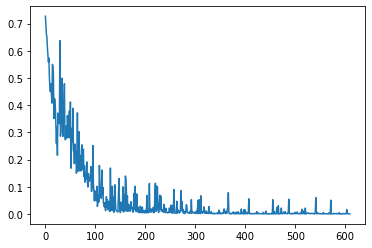

In [64]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

<AxesSubplot:>

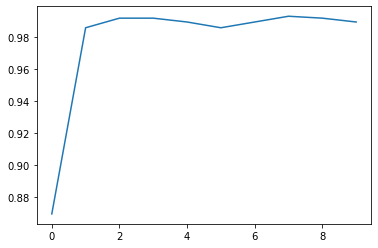

In [66]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy > 0.95.

In [67]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.9760479041916168
